In [1]:
import rpy2
import logging
import warnings
import anndata2ri
import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sb
import decoupler as dc
from tabnanny import verbose
import matplotlib.pyplot as plt
from gsva_prep import prep_gsva
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from matplotlib.pyplot import rcParams
from functions import pathway_analyses
from statsmodels.stats.multitest import multipletests
from rpy2.robjects.conversion import localconverter

In [2]:
def get_sys_dpi(width, height, diag):
    '''
    obtain dpi of system
    
    w: width in pixels (if unsure, go vist `whatismyscreenresolution.net`)
    h: height in pixels
    d: diagonal in inches
    '''
    w_inches = (diag**2/ (1 + height**2/width**2))**0.5
    return round(width/w_inches)

In [3]:
# # Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# # Automatically convert rpy2 outputs to pandas dataframes
# pandas2ri.activate()
# anndata2ri.activate()
# %load_ext rpy2.ipython

warnings.filterwarnings("ignore", category=PendingDeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

rcParams['figure.dpi'] = get_sys_dpi(1512, 982, 14.125)
#rcParams['figure.figsize']=(4,4) #rescale figures

sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()



-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                         9.2.0
anndata2ri                  1.1
appnope                     0.1.2
asttokens                   NA
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
bottleneck                  1.3.5
cffi                        1.15.1
cloudpickle                 2.2.0
colorama                    0.4.4
cycler                      0.10.0
cython_runtime              NA
dask                        2022.11.0
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
decoupler                   1.4.0
defusedxml                  0.7.1
entrypoints                 0.4
executing                   0.8.3
fsspec                      2022.10.0
functions                   NA
google                      NA
gsva_prep                   NA
h5py                        3.7.0
hypergeom_ufunc             NA
igraph                      0.10.2
ipykernel        

# **Table of contents**:

  * <a href=#Reading>1. Reading in the data</a>
  * <a href=#Preprocessing>2. Systematic differential analysis of gene expression</a>

## **1. Parse Gene Core ontology (OBO Format)**

This is the basic version of the GO, filtered such that the graph is guaranteed to be acyclic and annotations can be propagated up the graph. The relations included are is a, part of, regulates, negatively regulates and positively regulates. This version excludes relationships that cross the 3 GO hierarchies.

The parsing is done with [**goscripts**](https://pmoris.github.io/goscripts/_build/html/source/README.html), a python script and package for Gene Ontology enrichment analysis.

In [4]:
from goscripts.goscripts.obo_tools import importOBO, completeChildHierarchy, buildGOtree

In [5]:
GOdict = importOBO('../data/pathway_databases/go_terms.obo', ignore_part_of=True)
# Generate the entire GO tree’s parent structure by walking through the hierarchy of each GO entry

Retrieved 47497 GO terms from /Users/temitopeleke/Documents/Research Documents/Research codes/mathys_reproduce/data/pathway_databases/go_terms.obo 

Adding secondary GO identifiers...



Next we build the entire GO tree parent and child structure for only `Biological Processes with GO ID GO:0008150` by walking through the hierarchy of each GO entry using `buildGOtree` and setting the `root_node = ['GO:0008150']`.

This function assigns all higher order ancestors (recursive parents) for each GO object, assigns immediate children, assigns all recursively found children, assign depth to each node.

In [6]:
# here we set the root node as "Biological Processes with GO ID GO:0008150"
buildGOtree(GOdict, root_nodes=['GO:0008150']) 
#completeChildHierarchy(GOdict) # Generates the entire GO tree’s child structure.

## **2. Reading in the data**

We load the preprocessed and annotated pathway differential scores across the following tests:

- `AD vs no-AD`
- `Late vs Early`
- `Early vs no-AD`
- `Late vs no-AD`


In [7]:
# load all pathways
pathway_scores = {}
cell_types = ["Excitatory", "Inhibitory", "Astrocyte", "Microglia", "Oligodendrocyte", "OPC",]
studies = ['allen_mtg', 'leng_etc', 'leng_sfg']
tests = ['early_vs_no', 'late_vs_early', 'ad_vs_no', 'late_vs_no']
for study in studies:
    pathway_scores[study] = {}
    for test in tests:
        pathway_scores[study][test] = pd.read_csv(f'../results/{test}/{study}_differentially_expressed_pathways.csv')
        pathway_scores[study][test]['shortened'] = pathway_scores[study][test]['pathway']

### **Get parent GO name at a certain node**

In [8]:
def get_parent_at_depth(goid, depth):
    
    """
    Given a Gene Ontology (GO) term ID and a desired depth in the GO hierarchy, this function returns the name of the
    first parent GO term at that depth.

    Parameters:
    -----------
    - goid (str): A string representing the GO term ID.
    - depth (int): An integer representing the desired depth in the GO hierarchy.

    Returns:
    --------
    - str: The name of the parent GO term at the desired depth in the GO hierarchy.

    """
        
    for parent in GOdict.get(goid).recursive_parents:
        if GOdict.get(parent).depth == depth:
            return GOdict.get(parent).name
        else:
            continue

### **Overall Overlap**

This section computes the overall overlap of pathways across all studies and generates a complete hierarchy of pathway nodes, including the parent name at each node.

In [9]:
go_node_depths = [1, 2, 3, 4, 5, 6, 7, 8]

for test_name in tests:
    eval_string = []
    for i, study in enumerate(pathway_scores.keys()):
        eval_string.append(f'set(pathway_scores["{study}"]["{test_name}"][pathway_scores["{study}"]["{test_name}"]["P.Value"]<0.05].pathway)')

    eval_string = '&'.join(eval_string)
    eval_list = list(eval(eval_string))
    df = pd.DataFrame()
    df['pathway'] = eval_list
    df['GO'] = [pathway.split(' ')[-1].strip('(').strip(')') for pathway in eval_list]
    
    for depth in go_node_depths:
        df[f'parent_at_node_{depth}'] = df['GO'].apply(lambda x: get_parent_at_depth(x, depth))

    df.to_csv(f'../results/{test_name}/{test_name}_pathway_overlap.csv')

### **Heatmap showing select diffentially expressed pathways accross all celltypes in each study**

Next, we load a list of manually curated annotated pathways that we are interested in plotting. We then assign the parent at each node using the function `get_parent_at_depth()`.

In [10]:
go_node_depths = [1, 2, 3, 4, 5, 6, 7, 8]

pathways_to_annotate = pd.read_excel('../data/pathway_databases/pathways_to_annotate.xlsx')
pathways_to_annotate['GO'] = pathways_to_annotate['pathway'].apply(lambda x: x.split(' ')[-1].strip('(').strip(')'))

for depth in go_node_depths:
        pathways_to_annotate[f'parent_at_node_{depth}'] = pathways_to_annotate['GO'].apply(lambda x: get_parent_at_depth(x, depth))


View list of unique parents at a certain node

In [11]:
pathways_to_annotate['parent_at_node_3'].unique()

array(['positive regulation of molecular function', None,
       'positive regulation of biological process', 'defense response',
       'lipid homeostasis', 'cell surface receptor signaling pathway',
       'G protein-coupled receptor signaling pathway',
       'organonitrogen compound metabolic process', 'transport',
       'microtubule-based movement', 'cell differentiation',
       'organic cyclic compound metabolic process', 'autophagy',
       'cellular component organization',
       'developmental growth involved in morphogenesis',
       'cellular response to stress', 'neuron recognition',
       'cellular component morphogenesis',
       'positive regulation of cytosolic calcium ion concentration',
       'cell-cell adhesion', 'intracellular signal transduction',
       'monoatomic ion homeostasis', 'inorganic ion homeostasis',
       'response to oxygen-containing compound', 'axon ensheathment',
       'cell migration', 'cell-cell signaling', 'nervous system process',
      

Based on the pathways of interest, we can curate a list of parent nodes for each level. Only pathways that belong to those parents at each level will be selected for visualization.

In [12]:
parents_to_annotate = {
                        'node_1': [None,
                                   'immune system process',
                                   'cellular process',
                                   'metabolic process',
                                   'biological regulation',
                                   'response to stimulus',
                                   'homeostatic process',
                                   'localization',
                                  ],

############### PATHWAYS AT NODE 2 #############################################                                    

                        'node_2': [None,
                                   'regulation of molecular function',
                                   'response to stress',
                                   'chemical homeostasis',
                                   'regulation of biological process',
                                   'organic substance metabolic process',
                                   'establishment of localization',
                                   'cellular developmental process',
                                   'small molecule metabolic process',
                                   'cellular metabolic process',
                                   'cellular component organization or biogenesis',
                                   'developmental growth',
                                   'cellular response to stimulus',
                                   'cell recognition',
                                   'transmembrane transport',
                                   'cell adhesion',
                                   'catabolic process',
                                   'cellular homeostasis',
                                   'ensheathment of neurons',
                                   'cell motility',
                                   'signal transduction',
                                   'response to chemical',
                                   'regulation of biological quality',
                                   'activation of immune response',
                                   'regulation of pH',
                                   'maintenance of location',
                                   'leukocyte activation',
                                   'anatomical structure formation involved in morphogenesis',
                                   'cell death',
                                   'cellular localization',
                                   'protein-containing complex localization',
                                   'meiotic cell cycle process',
                                   'membrane docking',
                                   'actin filament-based process'
                                   ],

############### PATHWAYS AT NODE3  #############################################      
#                               
                        "node_3": [None,
                                   'regulation of catalytic activity',
                                    'positive regulation of molecular function', 
                                    'defense response', 
                                    'lipid homeostasis',
                                    'G protein-coupled receptor signaling pathway',
                                    'macromolecule metabolic process', 
                                    'amide metabolic process',
                                    'establishment of localization in cell', 
                                    'cell differentiation',
                                    'nucleobase-containing small molecule metabolic process',
                                    'cellular component organization', 
                                    'developmental cell growth',
                                    'cellular response to stress', 
                                    'import across plasma membrane',
                                    'transport', 'cell-cell adhesion',
                                    'regulation of cellular process', 
                                    'monoatomic ion homeostasis',
                                    'cellular response to chemical stimulus', 
                                    'axon ensheathment',
                                    'cell migration', 
                                    'cell-cell signaling', 
                                    'nervous system process',
                                    'intracellular transport', 
                                    'response to salt',
                                    'vesicle localization', 
                                    'regulation of membrane potential',
                                    'cell development', 
                                    'amino acid metabolic process',
                                    'organic acid metabolic process',
                                    'cell surface receptor signaling pathway',
                                    'regulation of immune system process', 
                                    'cell-cell recognition',
                                    'organic hydroxy compound metabolic process',
                                    'regulation of cellular pH', 
                                    'maintenance of protein location',
                                    'glial cell activation',
                                    'regulation of multicellular organismal process',
                                    'cellular component assembly involved in morphogenesis',
                                    'regulation of metabolic process', 
                                    'regulation of localization',
                                    'cellular macromolecule localization',
                                    'positive regulation of biological process',
                                    'negative regulation of molecular function',
                                    'regulation of DNA-binding transcription factor activity',
                                    'neuron death', 
                                    'carbohydrate derivative metabolic process',
                                    'localization within membrane',
                                    'positive regulation of cytosolic calcium ion concentration',
                                    'regulation of growth', 
                                    'regulation of developmental process',
                                    'regulation of locomotion', 
                                    'regulation of response to stimulus',
                                    'response to nitrogen compound', 
                                    'response to wounding',
                                    'organelle localization by membrane tethering',
                                    ],

############### PATHWAYS AT NODE 5 ############################################# 
#                                    
                        "node_5": [None,
                                   'positive regulation of cyclase activity',
                                   'positive regulation of hydrolase activity', 
                                   'adenylate cyclase-activating G protein-coupled receptor signaling pathway',
                                   'adenylate cyclase-inhibiting G protein-coupled receptor signaling pathway',
                                   'synaptic vesicle cytoskeletal transport',
                                   'nucleoside triphosphate metabolic process',
                                   'organelle disassembly',
                                   'plasma membrane bounded cell projection organization',
                                   'neuron projection extension involved in neuron projection guidance',
                                   'mitochondrion transport along microtubule',
                                   'cell projection morphogenesis',
                                   'calcium ion transmembrane transport',
                                   'monoatomic cation transport', 
                                   'regulated exocytosis',
                                   'calcium-mediated signaling', 
                                   'ribonucleotide metabolic process',
                                   'cell-cell junction organization',
                                   'intracellular monoatomic cation homeostasis',
                                   'response to amyloid-beta', 
                                   'telencephalon cell migration',
                                   'cyclic-nucleotide-mediated signaling', 
                                   'trans-synaptic signaling',
                                   'endocytosis',
                                   'regulation of G protein-coupled receptor signaling pathway',
                                   'endoplasmic reticulum organization',
                                   'proteasomal protein catabolic process', 
                                   'synapse organization',
                                   'glutamine family amino acid metabolic process',
                                   'positive regulation of immune response',
                                   'mitochondrion organization', 
                                   'protein processing',
                                   'modulation of chemical synaptic transmission',
                                   'plasma membrane organization',
                                   'negative regulation of cyclase activity',
                                   'regulation of protein metabolic process',
                                   'negative regulation of cellular component organization',
                                   'regulation of monoatomic ion transport',
                                   'regulation of exocytosis',
                                   'regulation of intracellular signal transduction',
                                   'negative regulation of nitrogen compound metabolic process',
                                   'regulation of cell projection organization',
                                   'negative regulation of signal transduction',
                                   'regulation of programmed cell death',
                                   'positive regulation of cell communication',
                                   'regulation of defense response',
                                   'regulation of protein transport',
                                   'regulation of intracellular transport',
                                   'regulation of nervous system development',
                                   'regulation of neural precursor cell proliferation',
                                   'negative regulation of cell differentiation',
                                    'regulation of response to endoplasmic reticulum stress',
                                    'regulation of receptor binding',
                                    'positive regulation of macromolecule metabolic process',
                                    'monoatomic anion transport',
                                    'negative regulation of synaptic transmission',
                                    'regulation of transcription regulatory region DNA binding',
                                    'negative regulation of immune response',
                                    'regulation of cellular biosynthetic process',
                                    'protein-containing complex assembly', 
                                    'chromosome organization',
                                    'glycolipid metabolic process', 
                                    'lipoprotein localization',
                                    'negative regulation of catabolic process', 
                                    'lysosomal transport',
                                    'regulation of extracellular matrix organization',
                                    'regulation of apoptotic signaling pathway',
                                    'regulation of macrophage activation',
                                    'postsynaptic specialization organization',
                                    'membrane invagination',
                                    'regulation of axon extension',
                                    'membrane fusion',
                                    'regulation of monoatomic ion transmembrane transport',
                                    'regulation of adaptive immune response',
                                    'regulation of phosphorus metabolic process',
                                    'positive regulation of vasculature development',
                                    'positive regulation of endocytosis',
                                    'positive regulation of biosynthetic process',
                                    'regulation of cellular catabolic process',
                                    'positive regulation of cell growth',
                                    'extracellular matrix organization',
                                    'regulation of cell adhesion mediated by integrin',
                                    'regulation of endocytosis',
                                    'regulation of nervous system process',
                                    'positive regulation of secretion by cell',
                                    'regulation of lipid transport',
                                    'regulation of glutamate receptor signaling pathway',
                                    'regulation of lipid metabolic process',
                                    'regulation of neuron differentiation',
                                    'positive regulation of cell motility', 
                                    'regulation of secretion',
                                    'positive regulation of protein localization',
                                    'positive regulation of cellular component organization',
                                    'membrane assembly', 
                                    'presynaptic membrane organization',
                                    'protein localization to cell junction',
                                    'regulation of monoatomic ion transmembrane transporter activity',
                                    'regulation of vasculature development',
                                    'regulation of extent of cell growth',
                                    'regulation of response to oxidative stress',
                                    'regulation of DNA metabolic process',
                                    'regulation of neuron death', 
                                    'regulation of cell migration',
                                    'regulation of protein localization',
                                    'regulation of protein-containing complex assembly',
                                    'regulation of cell junction assembly',
                                    'regulation of synapse organization', 
                                    'axo-dendritic transport',
                                    'negative regulation of cell cycle',
                                    'DNA damage checkpoint signaling',
                                    'vesicle-mediated transport in synapse',
                                    'actin filament-based transport',
                                    ],

############### PATHWAYS AT NODE 6 #############################################                                    

                        "node_6": [None,
                                   'positive regulation of adenylate cyclase activity',
                                   # 'regulation of endopeptidase activity',  
                                   'axonal transport',
                                   # 'ribonucleoside triphosphate metabolic process',
                                   # 'mitochondrion disassembly', 
                                   'neuron projection development',
                                   # 'plasma membrane bounded cell projection morphogenesis',
                                   'calcium ion transmembrane import into cytosol',
                                   'metal ion transport', 
                                   # 'cyclic nucleotide metabolic process',
                                   # 'nucleotide catabolic process',
                                   'anterograde trans-synaptic signaling',
                                   'receptor-mediated endocytosis',
                                   'negative regulation of G protein-coupled receptor signaling pathway',
                                   'protein quality control for misfolded or incompletely synthesized proteins',
                                   'synapse assembly', 
                                   # 'dicarboxylic acid catabolic process',
                                   # 'dicarboxylic acid metabolic process',
                                   'negative regulation of protein metabolic process',
                                   'regulation of plasma membrane bounded cell projection organization',
                                   'negative regulation of calcium ion transport',
                                   'regulation of metal ion transport',
                                   'regulation of regulated secretory pathway',
                                   'negative regulation of intracellular signal transduction',
                                   'regulation of protein kinase activity',
                                   'regulation of monoatomic cation transmembrane transport',
                                   'negative regulation of cation channel activity',
                                   'endoplasmic reticulum calcium ion homeostasis',
                                   'negative regulation of programmed cell death',
                                   'positive regulation of intracellular signal transduction',
                                   #'regulation of establishment of protein localization',
                                   'regulation of neurogenesis',
                                   'negative regulation of potassium ion transport',
                                   'regulation of apoptotic process',
                                   'regulation of receptor-mediated endocytosis',
                                   'regulation of synaptic transmission, glutamatergic',
                                   # 'regulation of RNA biosynthetic process',
                                   'neuron projection organization',
                                   'regulation of proteasomal protein catabolic process',
                                   'regulation of phagocytosis', 
                                   #'protein localization to vacuole',
                                   'regulation of calcium-mediated signaling',
                                   # 'positive regulation of extracellular matrix organization',
                                   # 'positive regulation of programmed cell death',
                                   'regulation of microglial cell activation',
                                   'mitochondrial calcium ion homeostasis',
                                   'positive regulation of potassium ion transport',
                                   'positive regulation of calcium ion transport',
                                   'postsynaptic density organization',
                                   'plasma membrane invagination',
                                   'regulation of acute inflammatory response',
                                   'regulation of phosphate metabolic process',
                                   'regulation of neuroinflammatory response',
                                   # 'apoptotic mitochondrial changes',
                                   'positive regulation of amide metabolic process',
                                   'positive regulation of phagocytosis',
                                   'regulation of astrocyte differentiation',
                                   'regulation of autophagy',
                                   'positive regulation of gene expression',
                                   'regulation of sterol transport', 
                                   # 'regulation of neuron migration',
                                   'positive regulation of cell projection organization',
                                   'regulation of protein localization to cell surface',
                                   'positive regulation of sodium ion transport',
                                   'regulation of sodium ion transmembrane transporter activity',
                                   'regulation of synapse assembly',
                                   'regulation of glycoprotein metabolic process',
                                   'regulation of amyloid precursor protein catabolic process',
                                   'regulation of programmed necrotic cell death',
                                   'sarcoplasmic reticulum calcium ion transport',
                                   # 'negative regulation of cell cycle process',
                                   # 'organelle membrane fusion',
                                   ]
                       }

Filter the overall list of pathways of interest using the curated list of parents described above.

In [13]:
list_of_paths_to_annotate = pathways_to_annotate[pathways_to_annotate.parent_at_node_6.isin(parents_to_annotate['node_6'])]['pathway'].to_list()
#list_of_paths_to_annotate = pathways_to_annotate['pathway'].to_list()

In [14]:
%%R -i list_of_paths_to_annotate -i tests -i studies -o mat

library(readxl)
library(ComplexHeatmap)
library(circlize)
library(tidyr)

source('../scripts/functions/pathway_analyses.R')

cell_types = c("Excitatory", "Inhibitory", "Astrocyte", "Microglia", "Oligodendrocyte", "OPC")

# import the renamed-pathway names

print('importing pathway renaming convention')

path_names_go <- as.data.frame(read_excel('../data/pathway_databases/pathways_to_annotate.xlsx'))
# path_names_go <- data.frame(pathway = unique(path_names_go$pathway))
rownames(path_names_go) <- path_names_go$pathway

# shortened names of pathways that will be annotated
names = as.vector(list_of_paths_to_annotate)

# import data from pathway anaylsis

# Loop over each study in a vector of studies
for (study in studies) {
  
  # Loop over each test in a vector of tests
  for (test_name in tests) {
    # Read in pathway data from a CSV file for the current test and study
    pathway_scores <- as.data.frame(read.csv(sprintf('../results/%s/%s_differentially_expressed_pathways.csv', test_name, study), header=TRUE))
     pathway_scores <- pathway_scores[pathway_scores$pathway %in% rownames(path_names_go), ]
    
    # Filter the pathway data to select only significant pathways
    pathway_scores[pathway_scores$P.Value > 0.05, "score_adj"] <- 0
    pathway_scores_subset <- pathway_scores[, c("pathway", "celltype", "score_adj")]
    pivot_table <- pathway_scores_subset %>% pivot_wider(names_from = "celltype", values_from = "score_adj")

    # Set pathway column as row names
    pivot_table <- as.data.frame(pivot_table)

    # Set the 'pathway' column as the row names (index)
    row.names(pivot_table) <- pivot_table$pathway

    # Remove the 'pathway' column from the data frame
    pivot_table$pathway <- NULL
    mat <- pivot_table[, cell_types] 
    

    # draw heatmap for all GO pathways
    print('drawing heatmaps - GO')
    unique = mat[unname(rowSums(abs(mat)>1.3)==1),] # obtain cell_type_specific pathways.
    shared_2 = mat[unname(rowSums(abs(mat)>1.3)>1),] # obtain shared pathways

    h1 = get_go_hmap(unique, names, path_names_go, 'shortened_name')
    h2 = get_go_hmap(shared_2, names, path_names_go, 'shortened_name')

    pdf(paste0('../results/', test_name, '/', study, '_filtered_diff_exp_paths','.pdf'), height = 45, width = 17.5)
    print(h1%v%h2)
    dev.off()
  }
}


[1] "importing pathway renaming convention"
New names:
• `` -> `...1`
[1] "drawing heatmaps - GO"
[1] "drawing heatmaps - GO"
[1] "drawing heatmaps - GO"
[1] "drawing heatmaps - GO"
[1] "drawing heatmaps - GO"
[1] "drawing heatmaps - GO"
[1] "drawing heatmaps - GO"
[1] "drawing heatmaps - GO"
[1] "drawing heatmaps - GO"
[1] "drawing heatmaps - GO"
[1] "drawing heatmaps - GO"
[1] "drawing heatmaps - GO"


**Using Python: Filtered Cell-type-specific Pathways**

heatmap for select cell-type-specific pathways in ALLEN_MTG for EARLY_VS_NO test


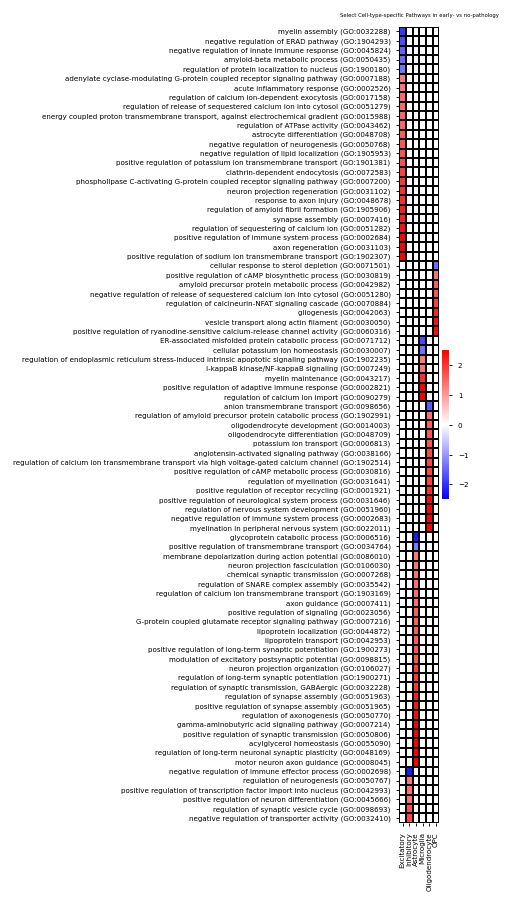

heatmap for select cell-type-specific pathways in ALLEN_MTG for LATE_VS_EARLY test


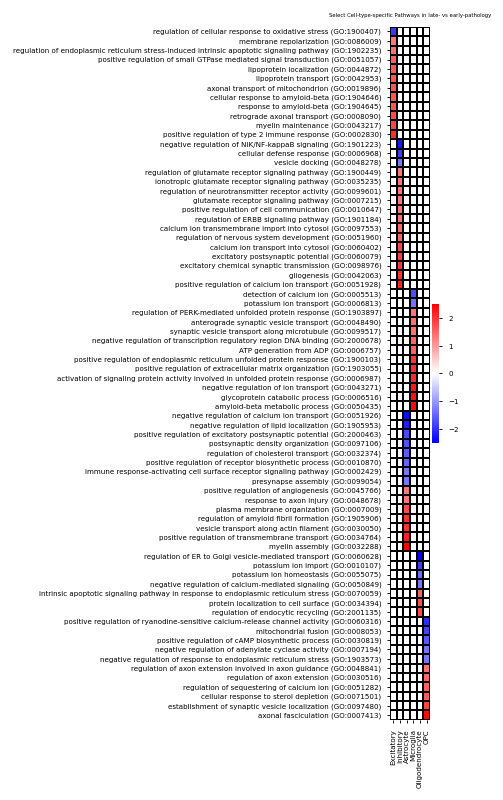

heatmap for select cell-type-specific pathways in ALLEN_MTG for AD_VS_NO test


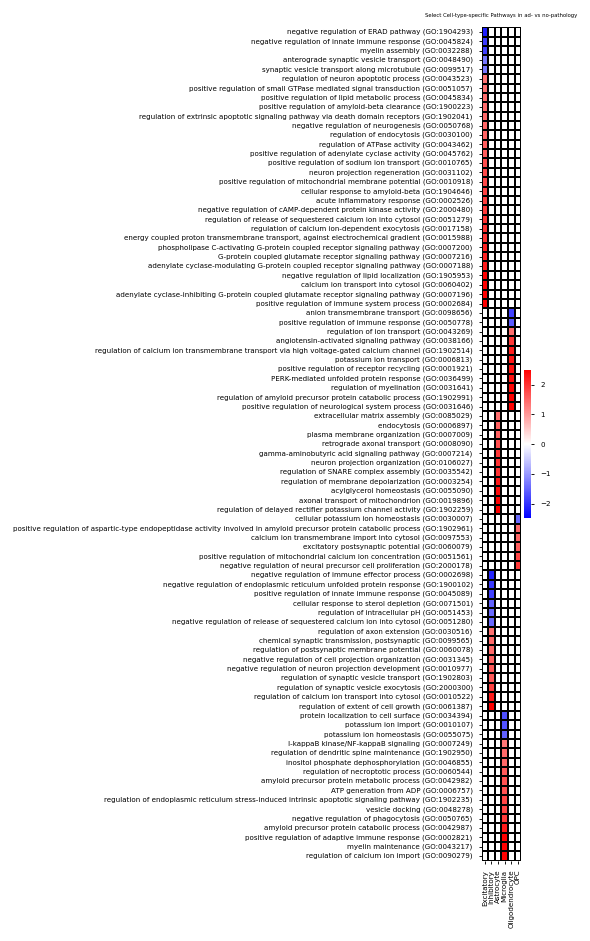

heatmap for select cell-type-specific pathways in ALLEN_MTG for LATE_VS_NO test


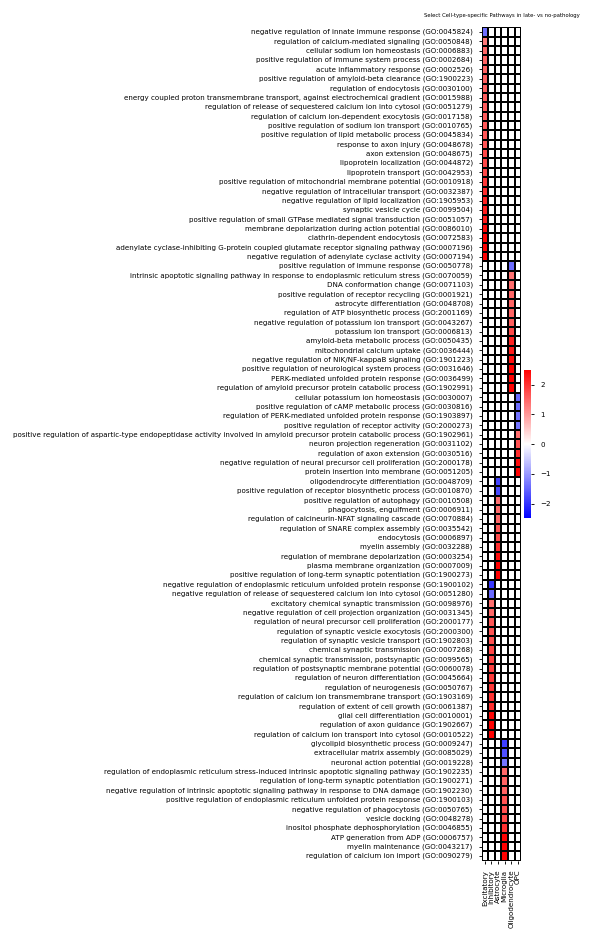

heatmap for select cell-type-specific pathways in LENG_ETC for EARLY_VS_NO test


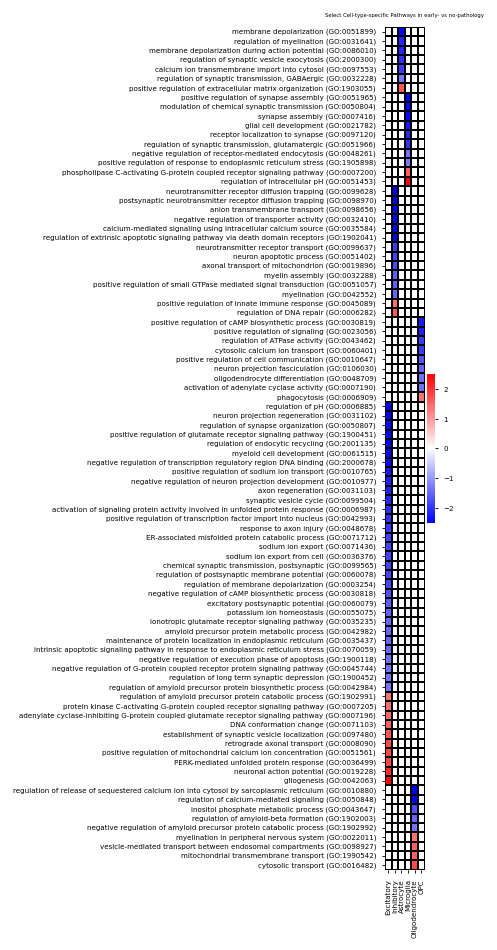

heatmap for select cell-type-specific pathways in LENG_ETC for LATE_VS_EARLY test


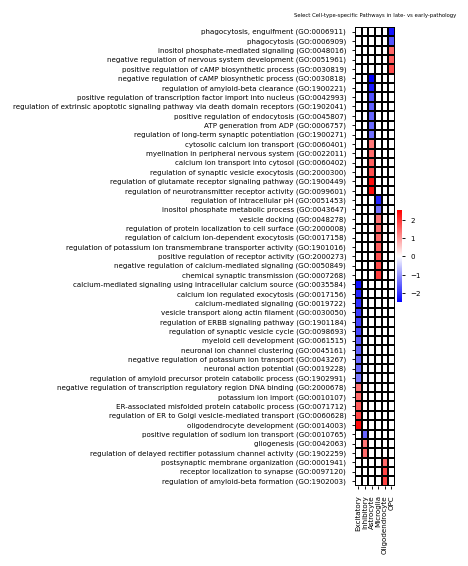

heatmap for select cell-type-specific pathways in LENG_ETC for AD_VS_NO test


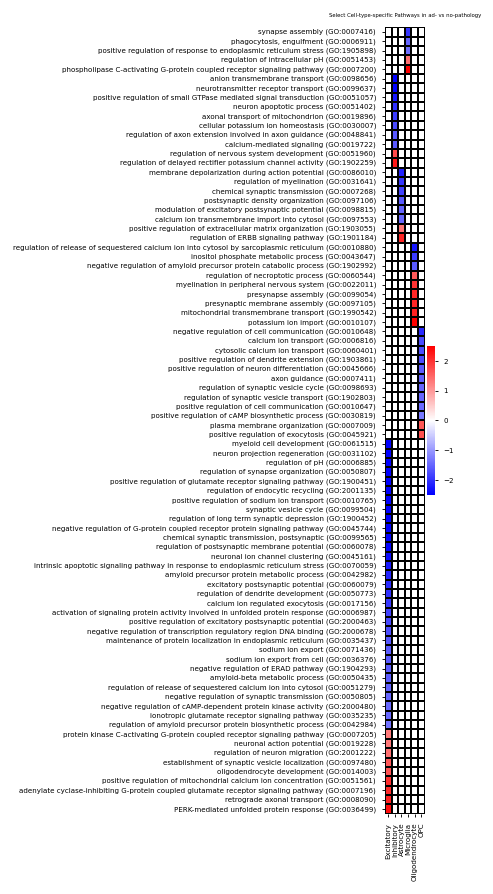

heatmap for select cell-type-specific pathways in LENG_ETC for LATE_VS_NO test


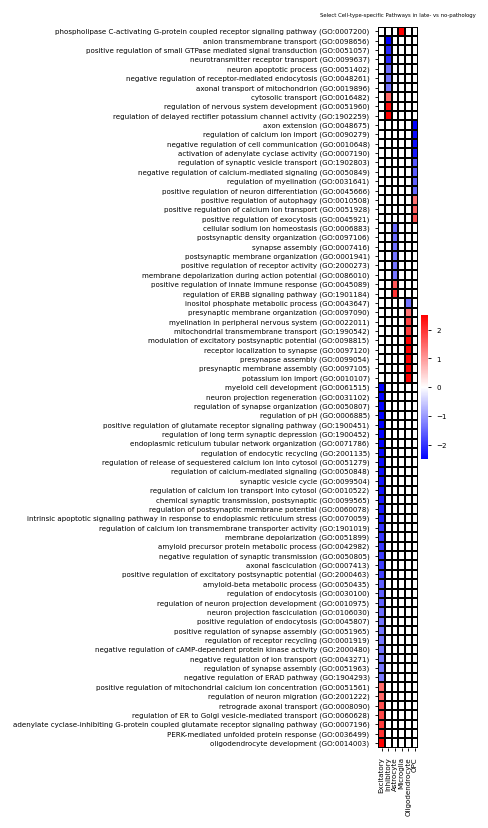

heatmap for select cell-type-specific pathways in LENG_SFG for EARLY_VS_NO test


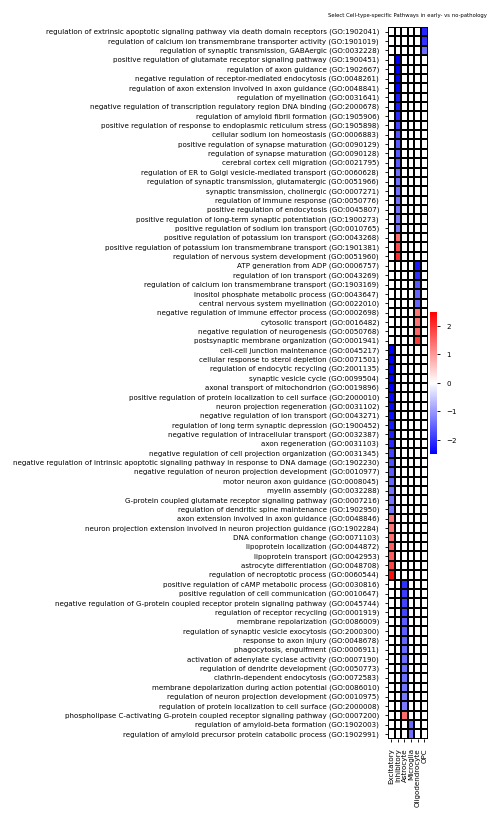

heatmap for select cell-type-specific pathways in LENG_SFG for LATE_VS_EARLY test


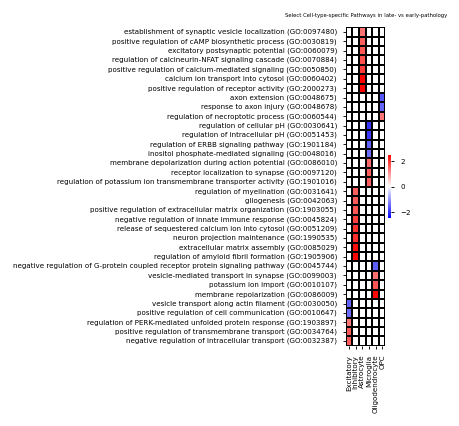

heatmap for select cell-type-specific pathways in LENG_SFG for AD_VS_NO test


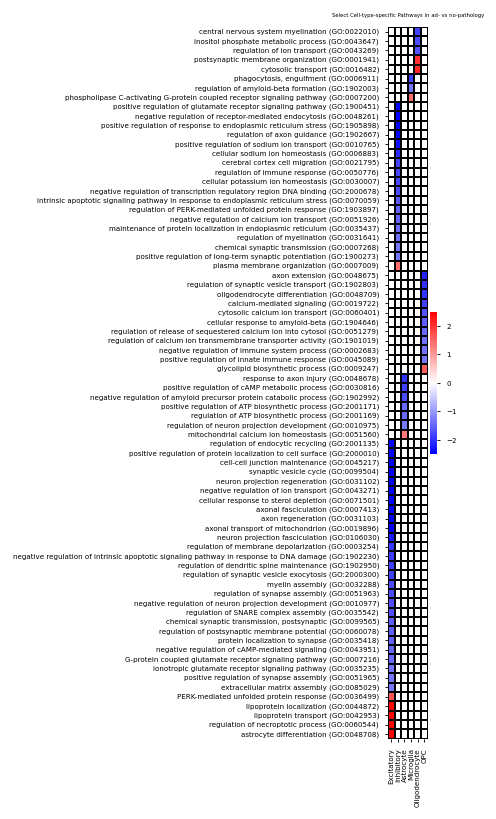

heatmap for select cell-type-specific pathways in LENG_SFG for LATE_VS_NO test


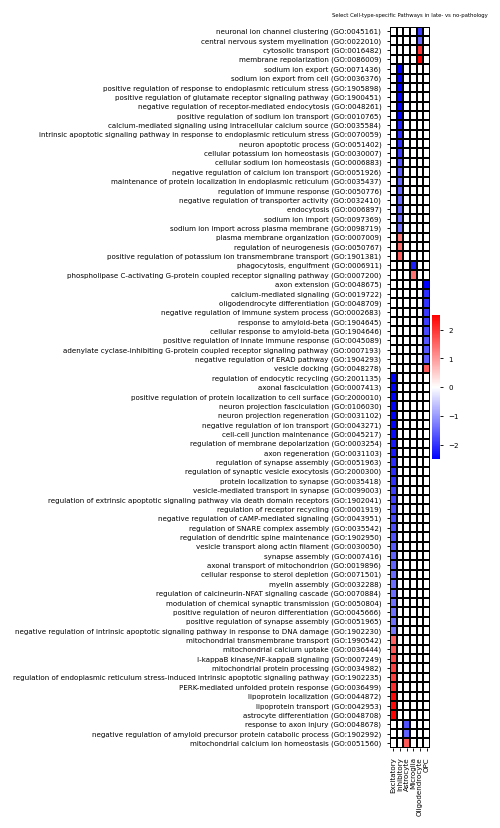

In [15]:
for study in studies:
    for test_name in tests:
        print(f'heatmap for select cell-type-specific pathways in {study.upper()} for {test_name.upper()} test')
        all_pathways = pathway_scores[study][test_name].copy()
        all_pathways = all_pathways[abs(all_pathways['score_adj'])>1.3]
        all_pathways.set_index('pathway', inplace=True)
        all_pathways = all_pathways[all_pathways.celltype.isin(cell_types)]
        pathway_analyses.plot_and_select_top_deps(all_pathways, list_of_paths_to_annotate, save_prefix=study,
                            save_name='cell_type_specific', filter=True, cell_type_specific=True,
                            cell_types=cell_types,
                            test_name=test_name, linewidths=0.015)

**Using Python: Filtered Shared Pathways**

heatmap for select cell-type-specific pathways in ALLEN_MTG for EARLY_VS_NO test


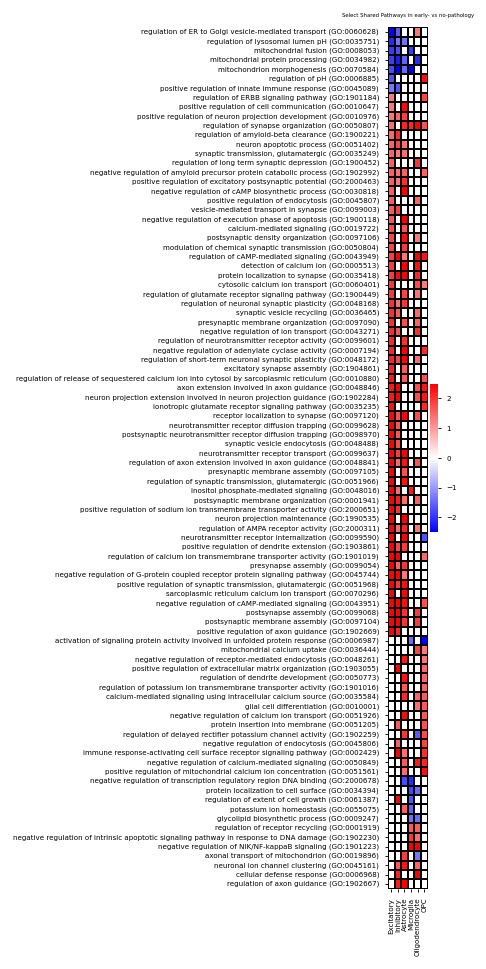

heatmap for select cell-type-specific pathways in ALLEN_MTG for LATE_VS_EARLY test


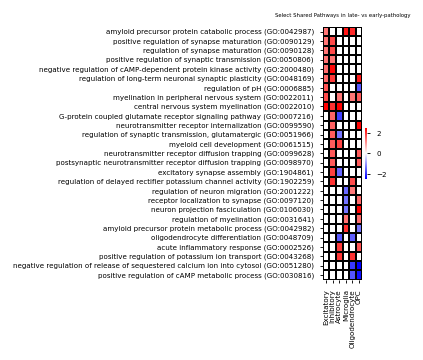

heatmap for select cell-type-specific pathways in ALLEN_MTG for AD_VS_NO test


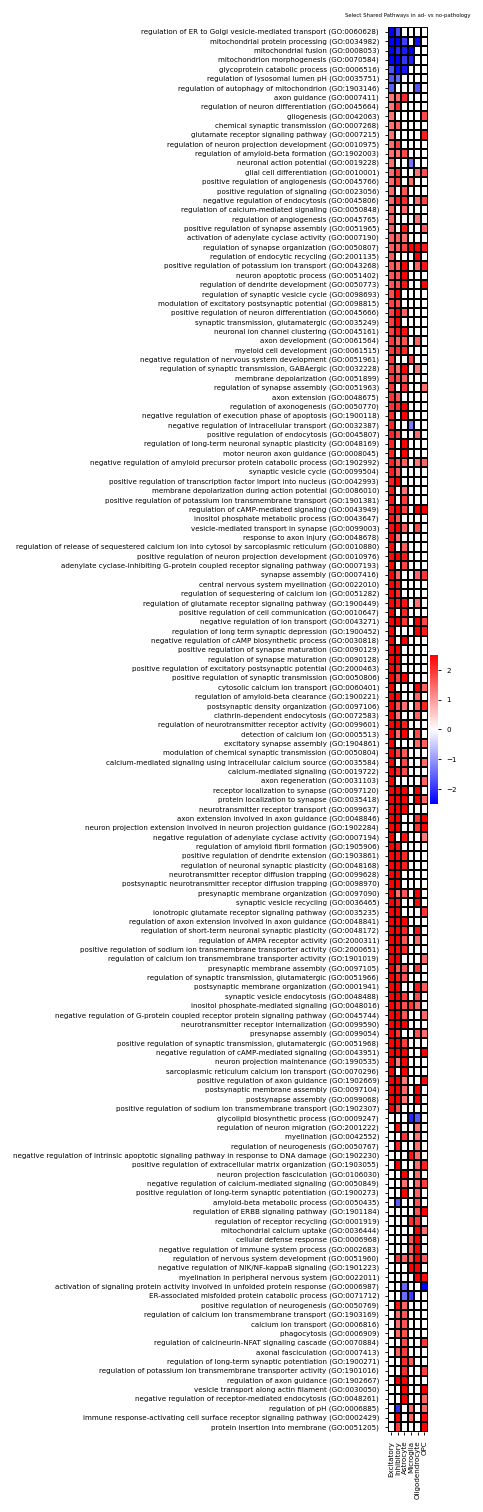

heatmap for select cell-type-specific pathways in ALLEN_MTG for LATE_VS_NO test


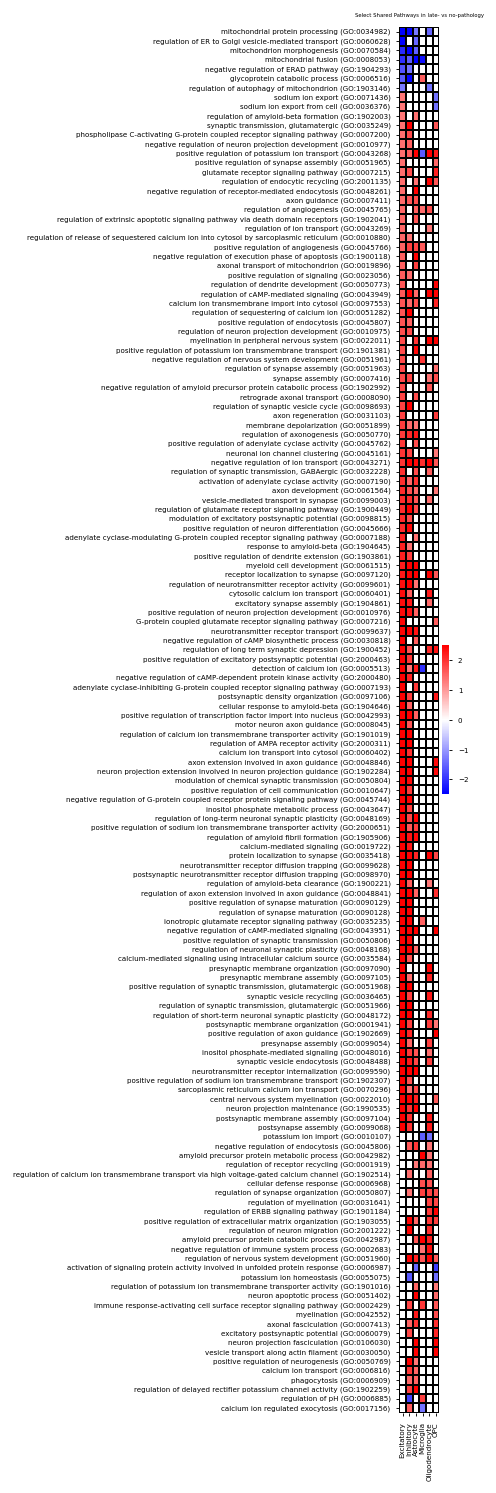

heatmap for select cell-type-specific pathways in LENG_ETC for EARLY_VS_NO test


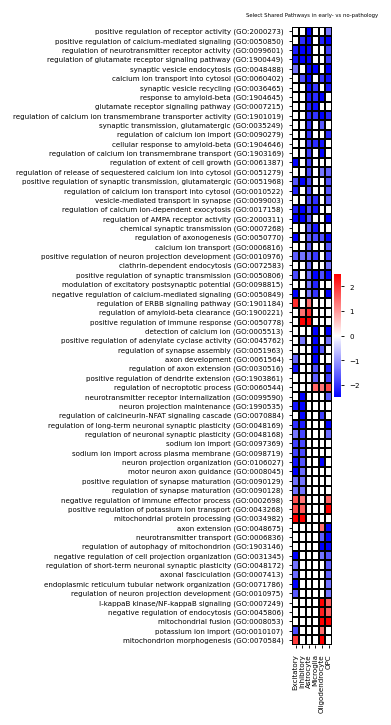

heatmap for select cell-type-specific pathways in LENG_ETC for LATE_VS_EARLY test


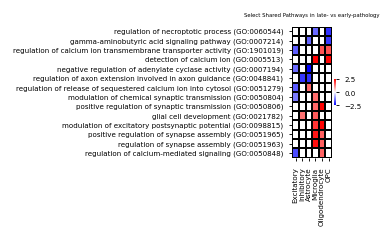

heatmap for select cell-type-specific pathways in LENG_ETC for AD_VS_NO test


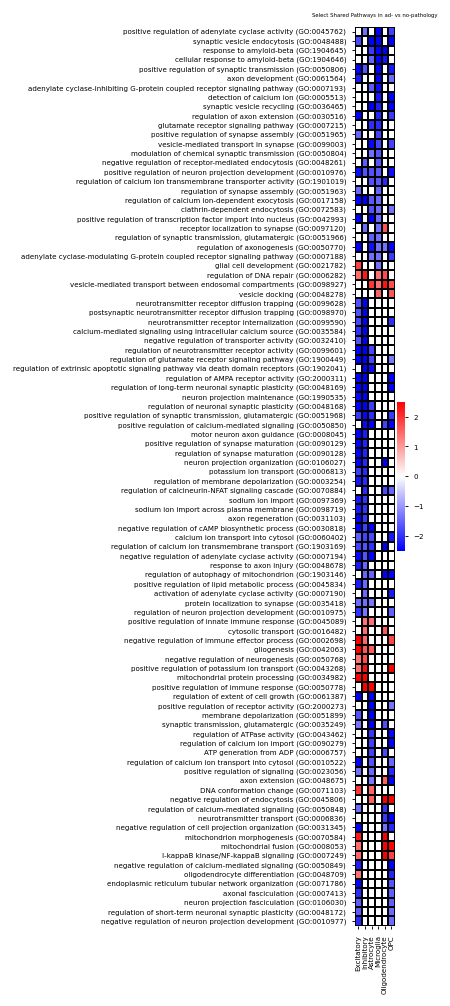

heatmap for select cell-type-specific pathways in LENG_ETC for LATE_VS_NO test


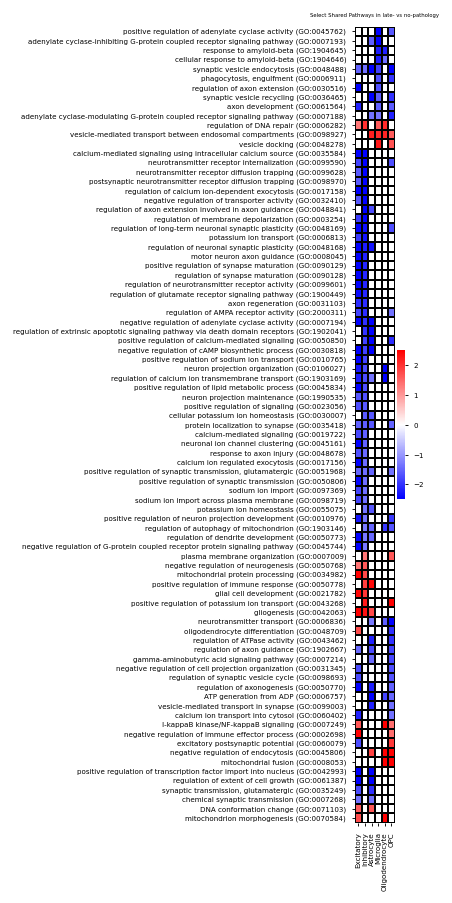

heatmap for select cell-type-specific pathways in LENG_SFG for EARLY_VS_NO test


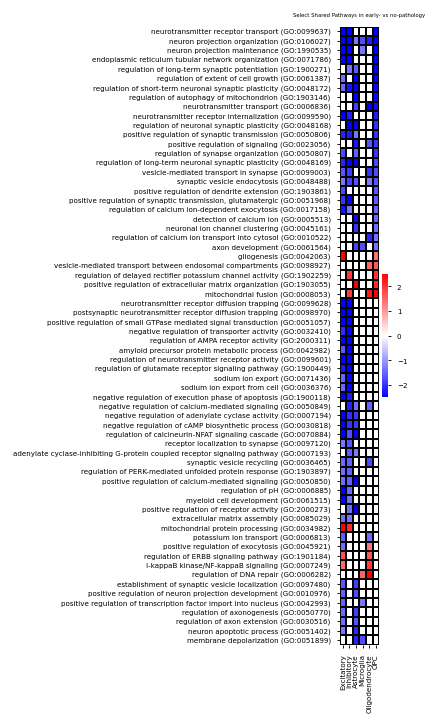

heatmap for select cell-type-specific pathways in LENG_SFG for LATE_VS_EARLY test


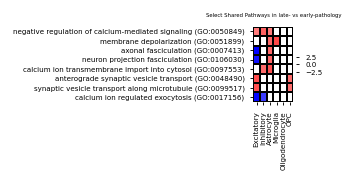

heatmap for select cell-type-specific pathways in LENG_SFG for AD_VS_NO test


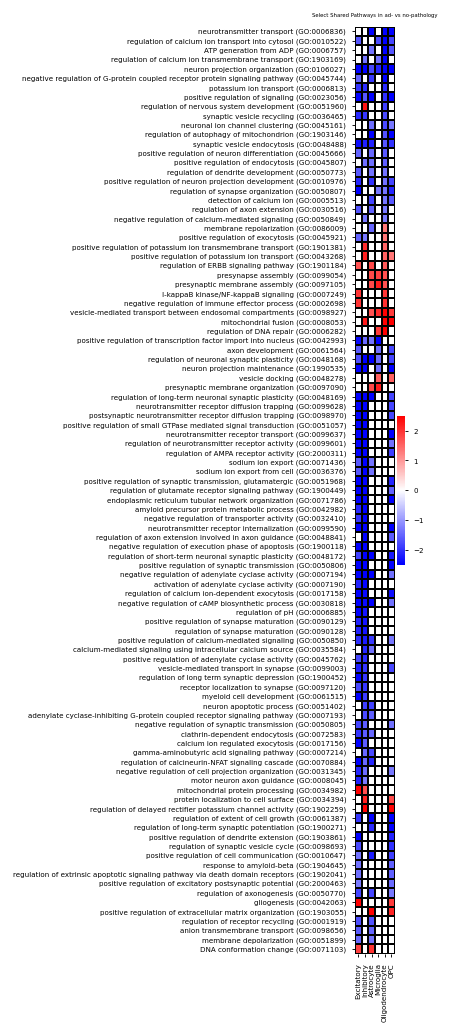

heatmap for select cell-type-specific pathways in LENG_SFG for LATE_VS_NO test


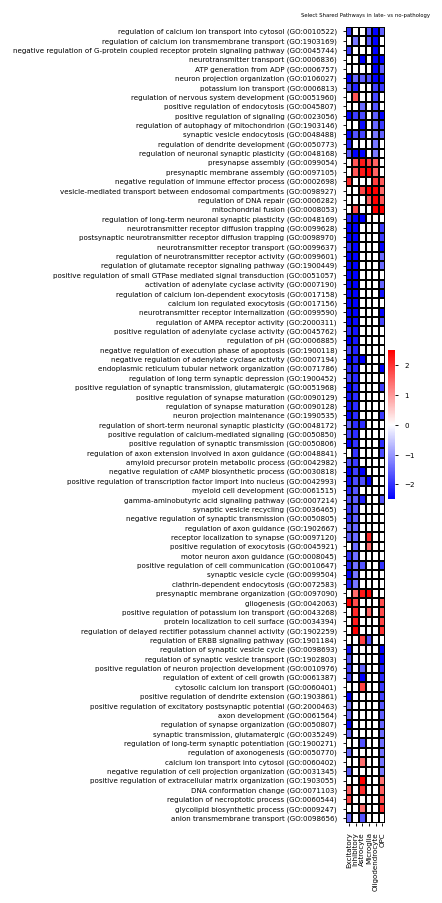

In [16]:
for study in studies:
    for test_name in tests:
        print(f'heatmap for select cell-type-specific pathways in {study.upper()} for {test_name.upper()} test')
        all_pathways = pathway_scores[study][test_name].copy()
        all_pathways = all_pathways[abs(all_pathways['score_adj'])>1.3]
        all_pathways.set_index('pathway', inplace=True)
        all_pathways = all_pathways[all_pathways.celltype.isin(cell_types)]
        pathway_analyses.plot_and_select_top_deps(all_pathways, list_of_paths_to_annotate, save_prefix=study,
                            save_name='broad', filter=True, cell_type_specific=False,
                            cell_types=["Excitatory", "Inhibitory", "Astrocyte", "Microglia", "Oligodendrocyte", "OPC",],
                            test_name=test_name, linewidths=0.015)
        

### **Barcharts showing the distribution of up- and down-regulated pathways in each celltype for each study**

Directionality of pathways in all studies in EARLY_VS_NO


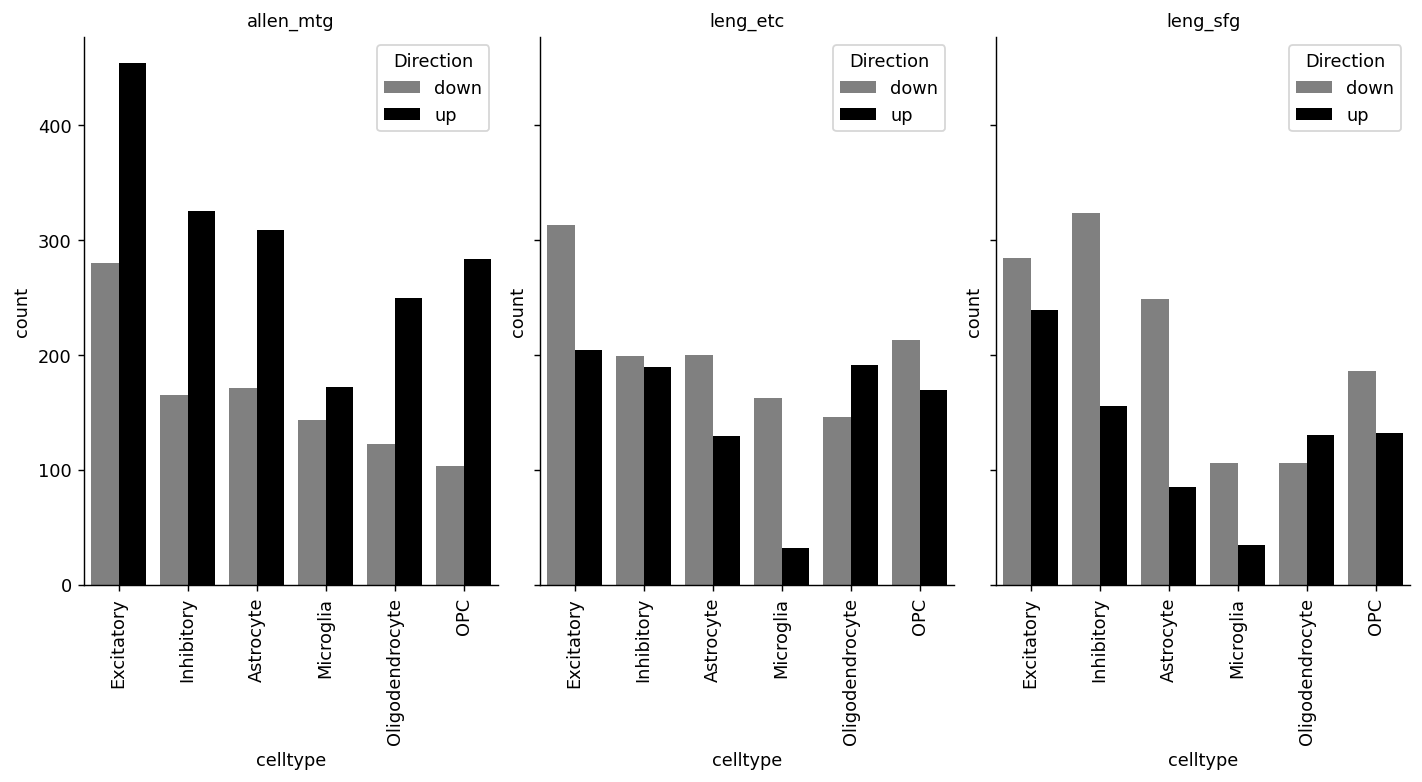

Directionality of pathways in all studies in LATE_VS_EARLY


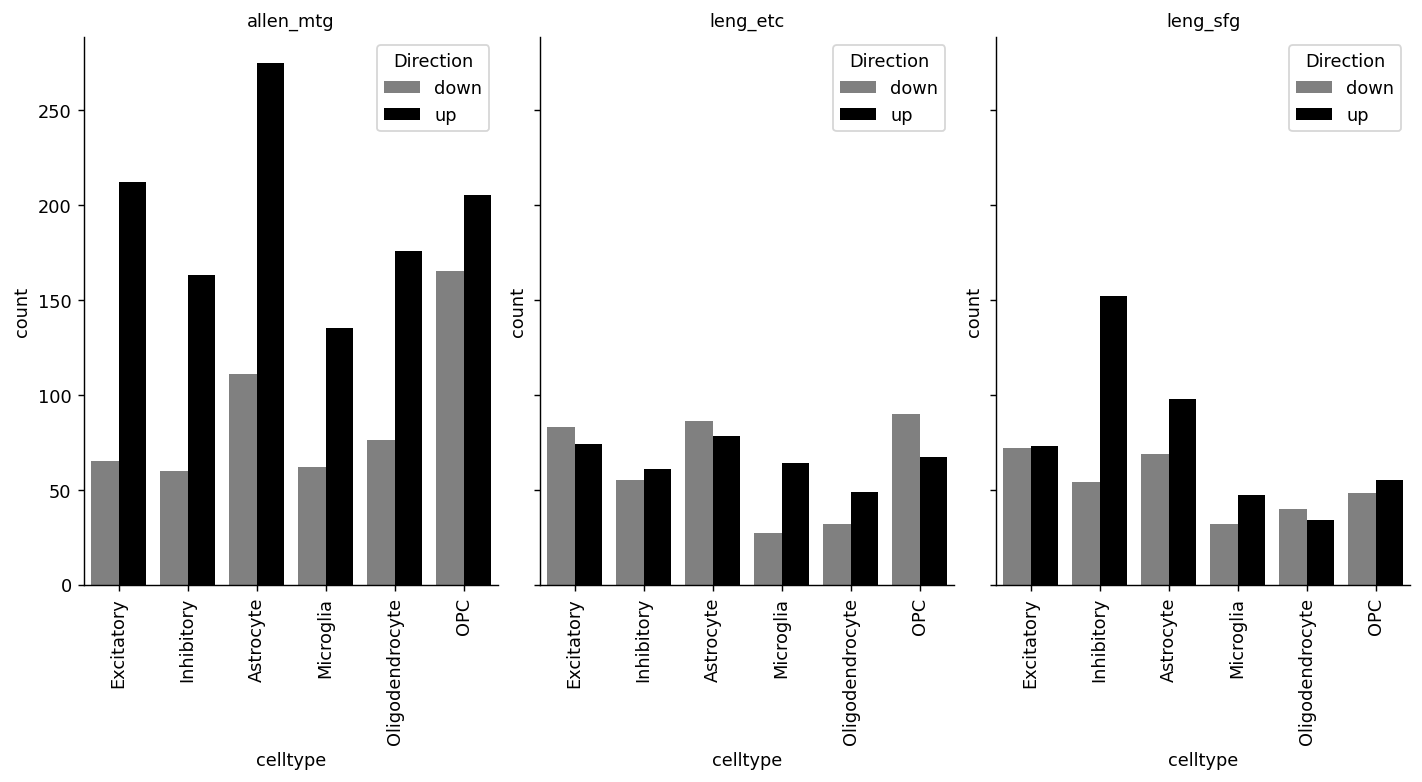

Directionality of pathways in all studies in AD_VS_NO


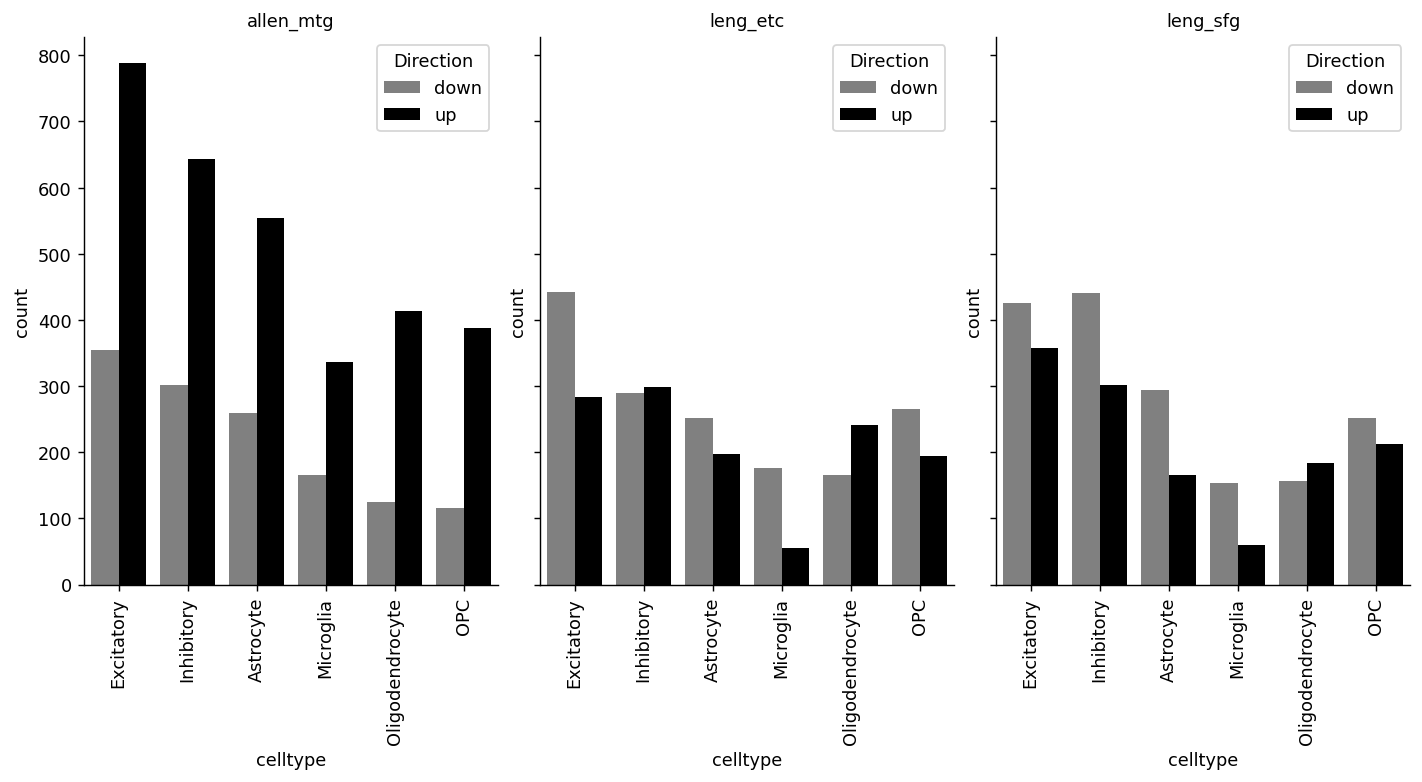

Directionality of pathways in all studies in LATE_VS_NO


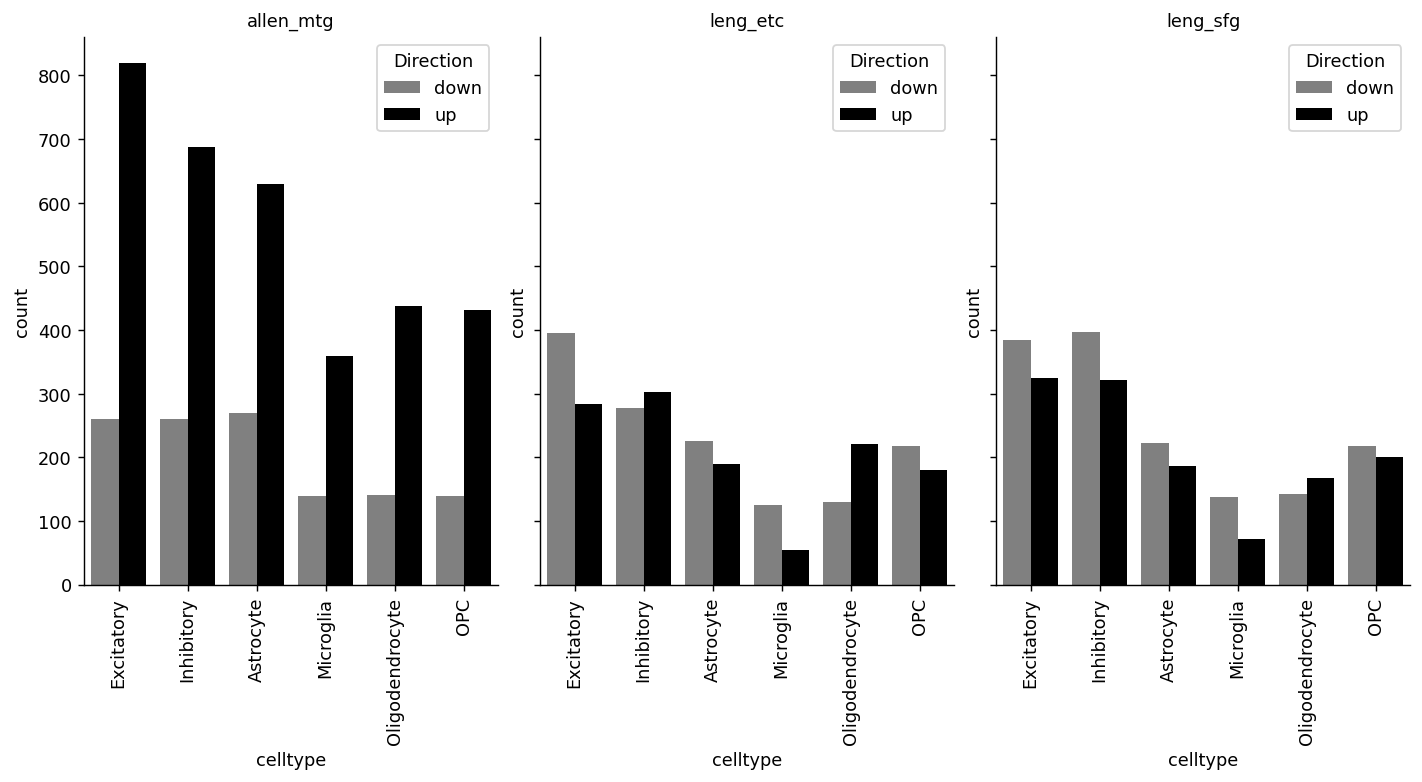

In [17]:
for test_name in tests:
    
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(11, 6), sharex=False, sharey = True, layout='constrained')
    axs = axs.ravel()

    print(f'Directionality of pathways in all studies in {test_name.upper()}')

    for ind, study in enumerate(studies):
        df = pathway_scores[study][test_name][pathway_scores[study][test_name].celltype.isin(cell_types)]
        df = df[abs(df.score_adj)>1.3]
        df['Direction'] = df.score_adj.apply(lambda x: 'down' if x<0 else "up")

        sb.countplot(data=df, x='celltype', hue='Direction', hue_order=['down', 'up'],
                     ax=axs[ind], linewidth=4, order=cell_types, 
                     palette={'up': 'black', 'down': 'grey'},
                     )


        axs[ind].set_title(study, fontdict={'fontsize': 10})
        axs[ind].yaxis.label.set_fontsize(10)
        axs[ind].set_xticklabels(cell_types, rotation=90,)
        axs[ind].spines[['right', 'top']].set_visible(False)
           
    plt.savefig(f'../results/{test_name}/directionality_distribution_of_pathways.pdf')
    plt.show()
    

### **Barcharts showing the GSVA enrichment score of pathways that are differentially expressed with different directionality across any group of celltypes in each study**

Directionality of pathways in all studies in EARLY_VS_NO
Number of pathways with opposing directionality in ALLEN_MTG: 116
Number of pathways with opposing directionality in LENG_ETC: 72
Number of pathways with opposing directionality in LENG_SFG: 41


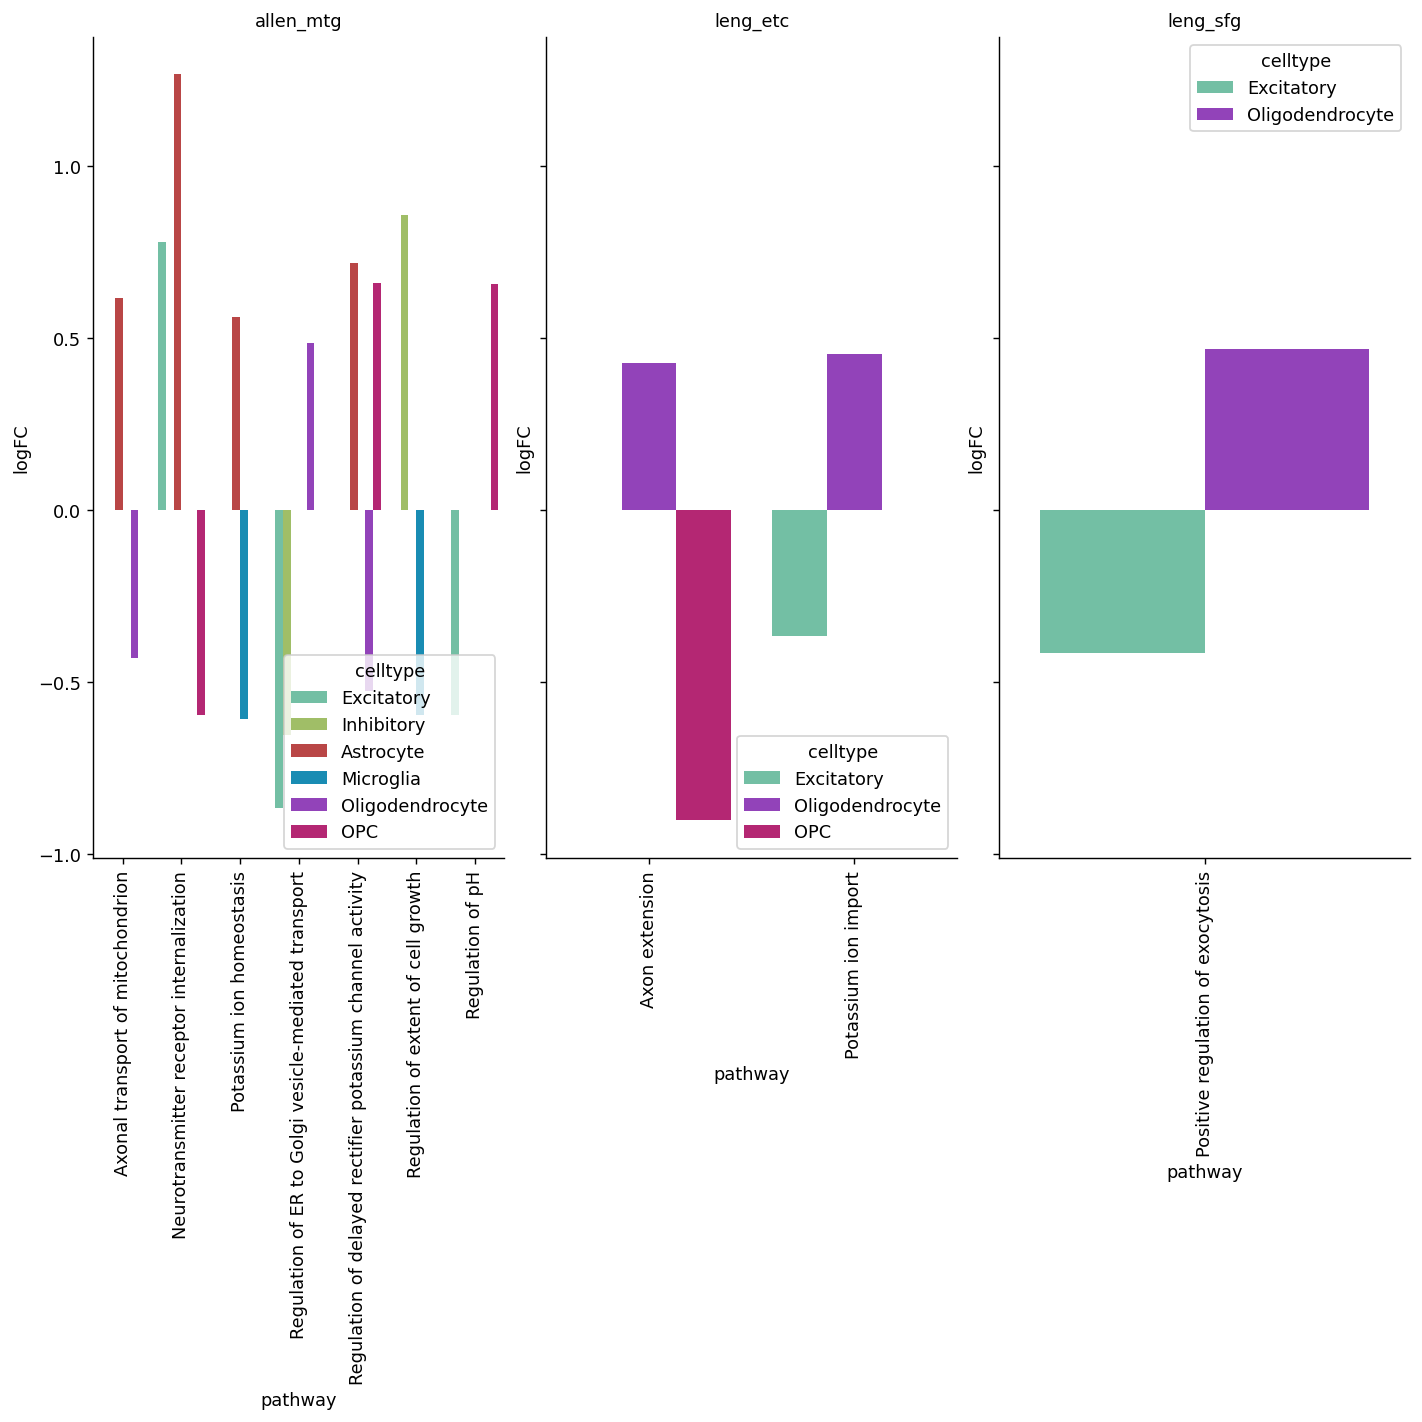

Directionality of pathways in all studies in LATE_VS_EARLY
Number of pathways with opposing directionality in ALLEN_MTG: 101
Number of pathways with opposing directionality in LENG_ETC: 34
Number of pathways with opposing directionality in LENG_SFG: 44


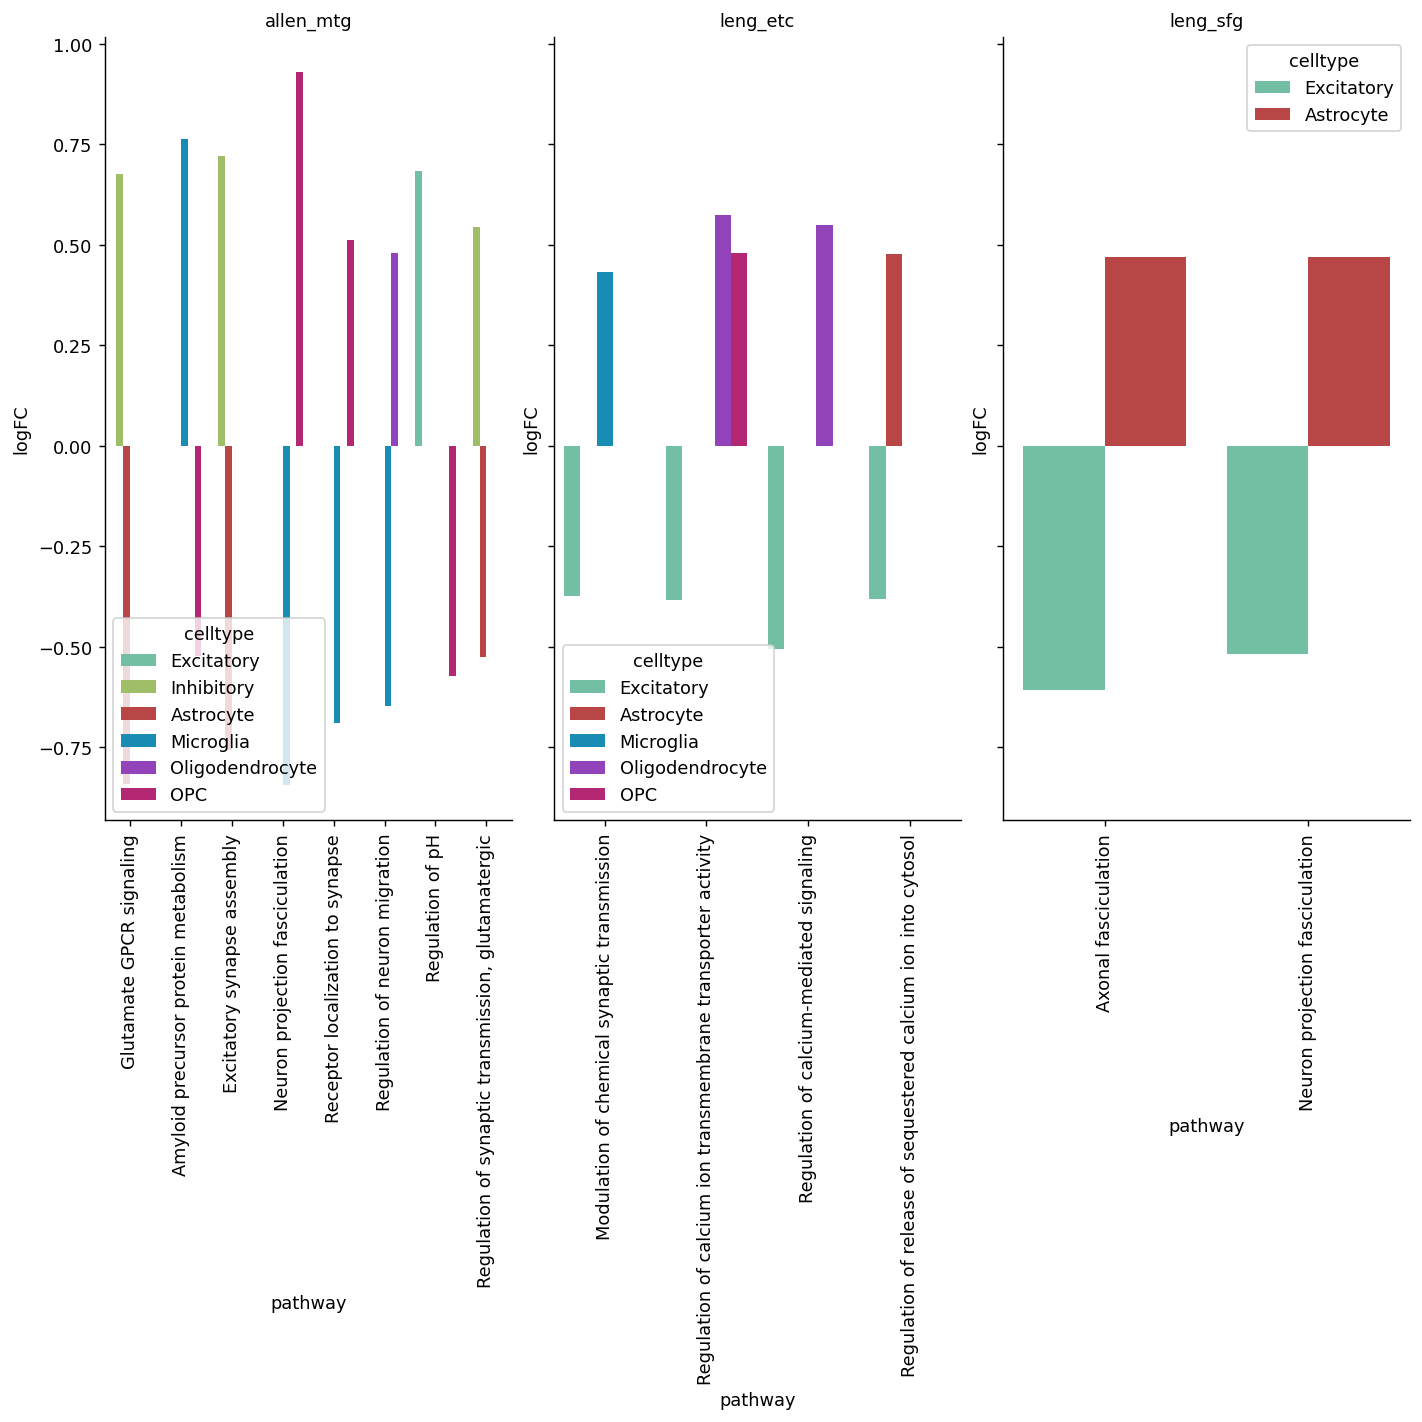

Directionality of pathways in all studies in AD_VS_NO
Number of pathways with opposing directionality in ALLEN_MTG: 144
Number of pathways with opposing directionality in LENG_ETC: 126
Number of pathways with opposing directionality in LENG_SFG: 65


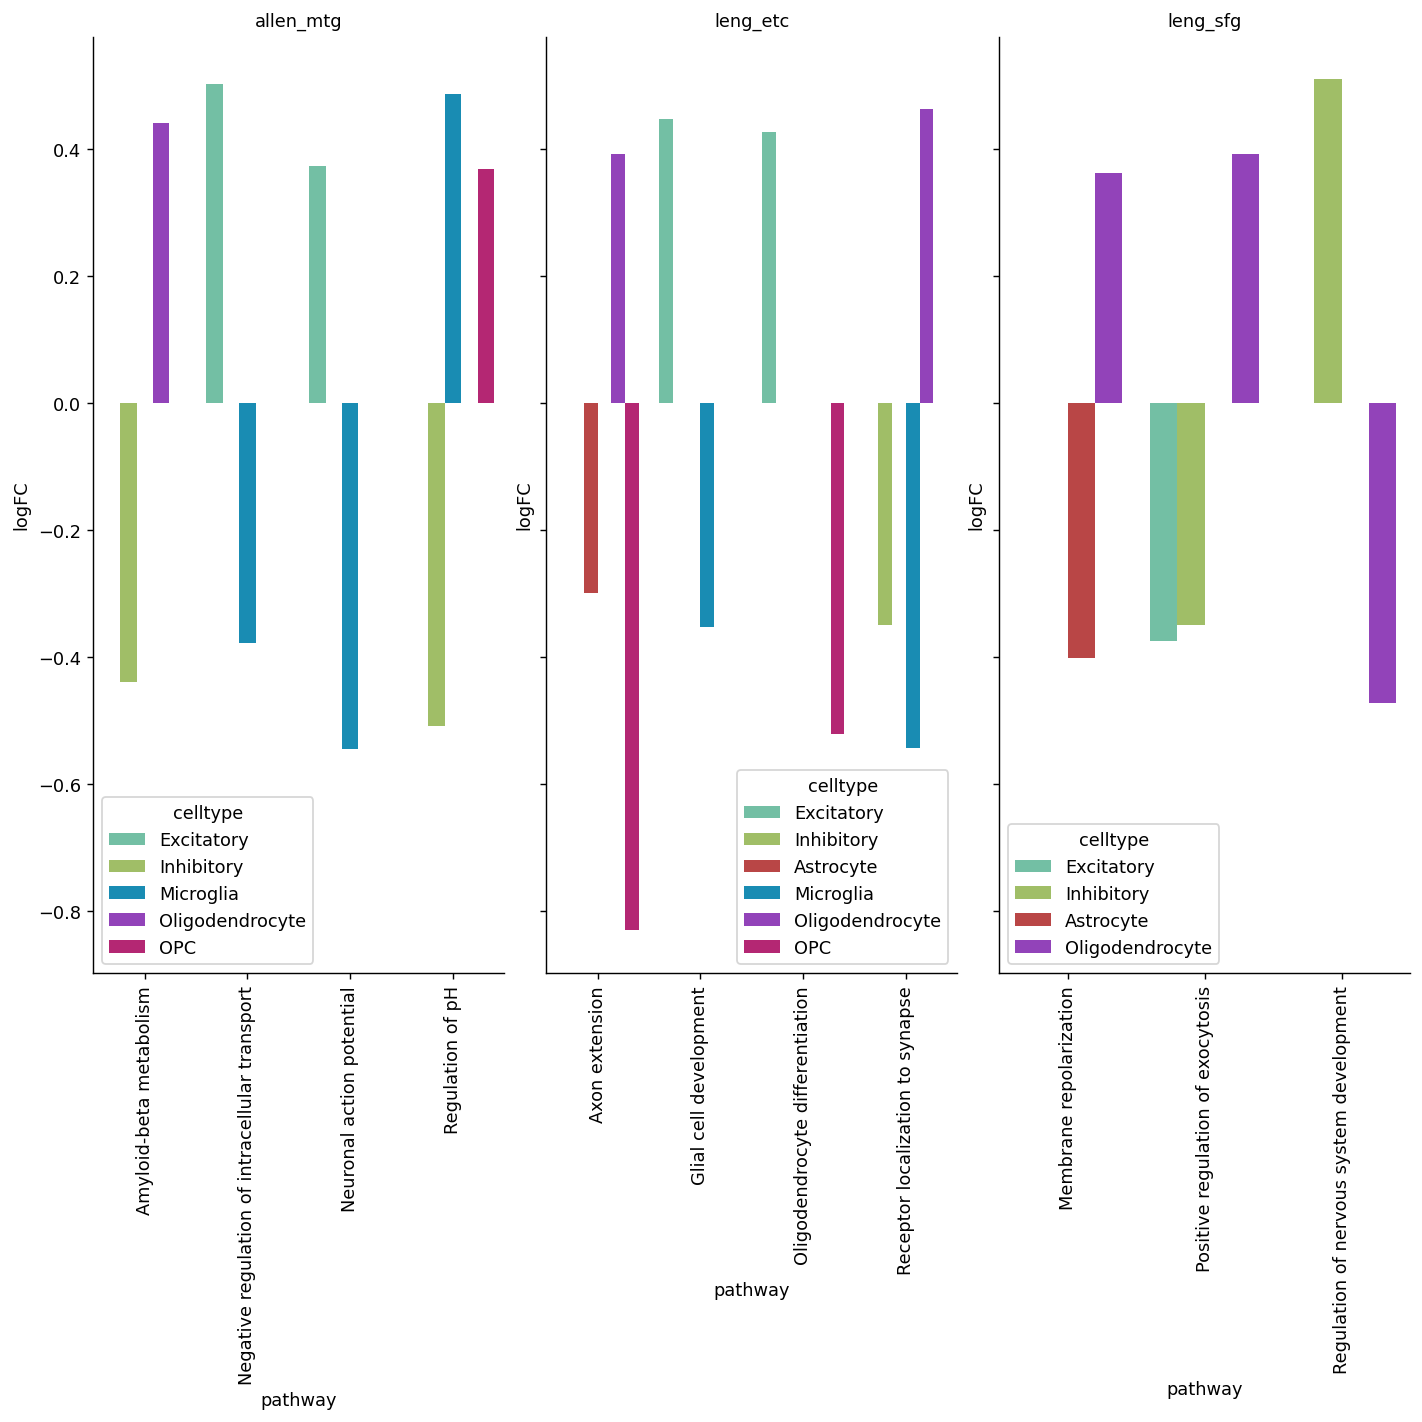

Directionality of pathways in all studies in LATE_VS_NO
Number of pathways with opposing directionality in ALLEN_MTG: 160
Number of pathways with opposing directionality in LENG_ETC: 91
Number of pathways with opposing directionality in LENG_SFG: 90


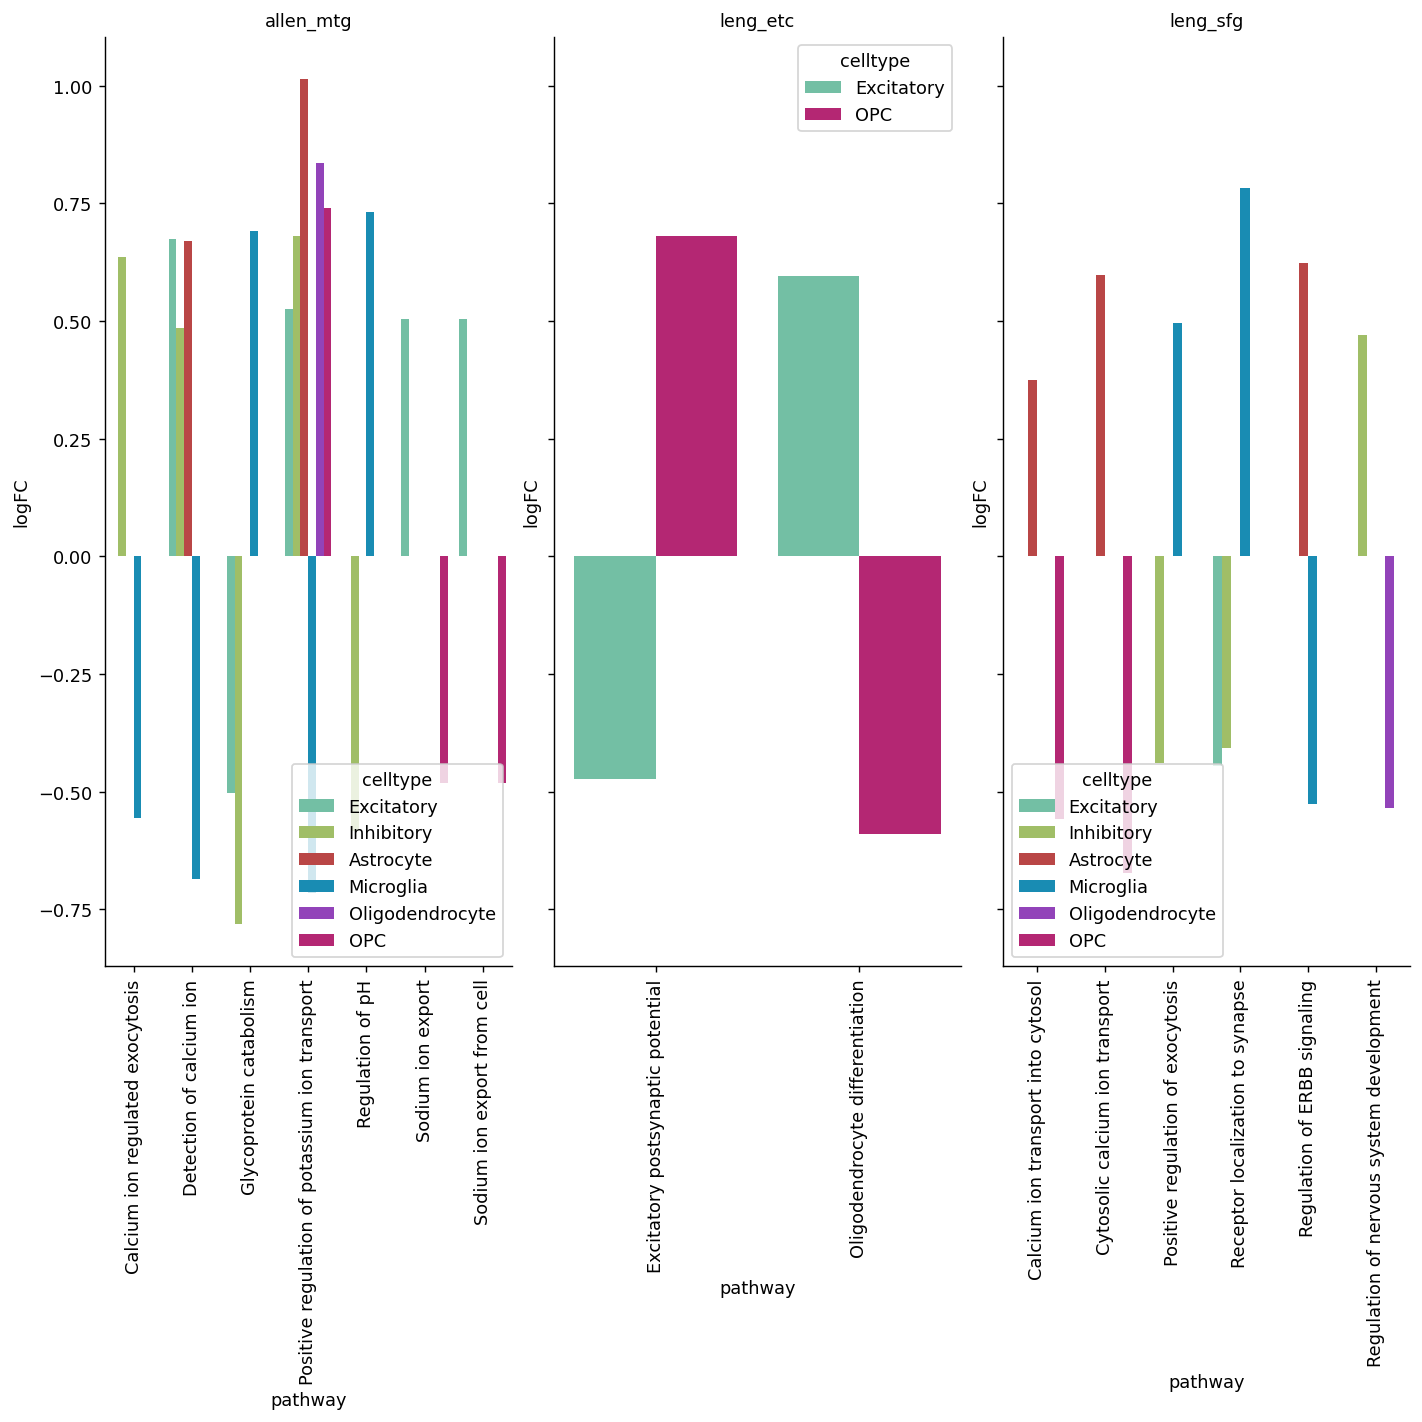

In [18]:
for test_name in tests:
    
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(11, 11), sharex=False, sharey = True, layout='constrained')
    axs = axs.ravel()

    print(f'Directionality of pathways in all studies in {test_name.upper()}')

    for ind, study in enumerate(studies):
        df = pathway_scores[study][test_name][pathway_scores[study][test_name].celltype.isin(cell_types)]
        df = df[abs(df.score_adj)>1.3]
        df['Direction'] = df.score_adj.apply(lambda x: 'down' if x<0 else "up")
        df = df[df.pathway.isin([key for key, value in dict(df['pathway'].value_counts() > 1).items() if value == True])]
        keys = dict(df.groupby('pathway')['Direction'].value_counts()).keys()
        
        pathways = [key[0] for key in keys if ((key[0], "down") in keys) and ((key[0], "up") in keys)]


        df = df[df.pathway.isin(pathways)]

        print(f'Number of pathways with opposing directionality in {study.upper()}: {len(df)}')

        if len(df[df.pathway.isin(list_of_paths_to_annotate)])>0:
            
            df = df[df.pathway.isin(list_of_paths_to_annotate)]
            df['pathway'] = df['pathway'].map(dict(zip(pathways_to_annotate.pathway,
                                                       pathways_to_annotate.shortened_name)))
           
        sb.barplot(data=df, x='pathway', y='logFC', hue='celltype', 
                   hue_order = sorted(list(df.celltype.unique()), key=lambda x: cell_types.index(x)),
                     ax=axs[ind], linewidth=4, #order=cell_types, 
                     palette={'Excitatory': [x/255 for x in [102, 204, 168]], 
                              'Inhibitory':  [x/255 for x in [164, 204, 89]],
                              'Astrocyte':  [x/255 for x in [204, 51, 51]],
                              'Microglia':  [x/255 for x in [0, 153, 204]],
                              'Oligodendrocyte':  [x/255 for x in [153, 48, 204]],
                              'OPC':  [x/255 for x in [204, 15, 117]],
                              },
                     )


        axs[ind].set_title(study, fontdict={'fontsize': 10})
        axs[ind].yaxis.label.set_fontsize(10)
        axs[ind].set_xticklabels(df.pathway.unique(), rotation=90,)
        axs[ind].spines[['right', 'top']].set_visible(False)
           
    plt.savefig(f'../results/{test_name}/directionality_of_select_pathways.pdf')
    plt.show()
    

### **Volcano plot of diffentially expressed pathways accross all celltypes in each study**


For each test and study, a volcano plot is generated to visualize differentially expressed pathways. Only select pathways passed in the names list are visualized. 

For instance, the following code visualizes pathways that contain `"calcium" or "amyloid"` in their name, and that meet the `nominal P.Value threshold of 0.05` (equivalent to an adjusted score: 


$$ sign(Log(Fold Change)) \times -Log_{10} ({P.Value})$$

and the `GSVA enrichment score difference of 0.25`.

`names = list(df[(df['pathway'].str.contains('|'.join(['calcium', 'amyloid']))) & (df['P.Value'] < 0.05) & (abs(df['GSVA enrichment score difference']) > 0.25)].index)`

To avoid visualization issues, only the GO ids are shown.

Volcano plot for pathways in ALLEN_MTG for EARLY_VS_NO test


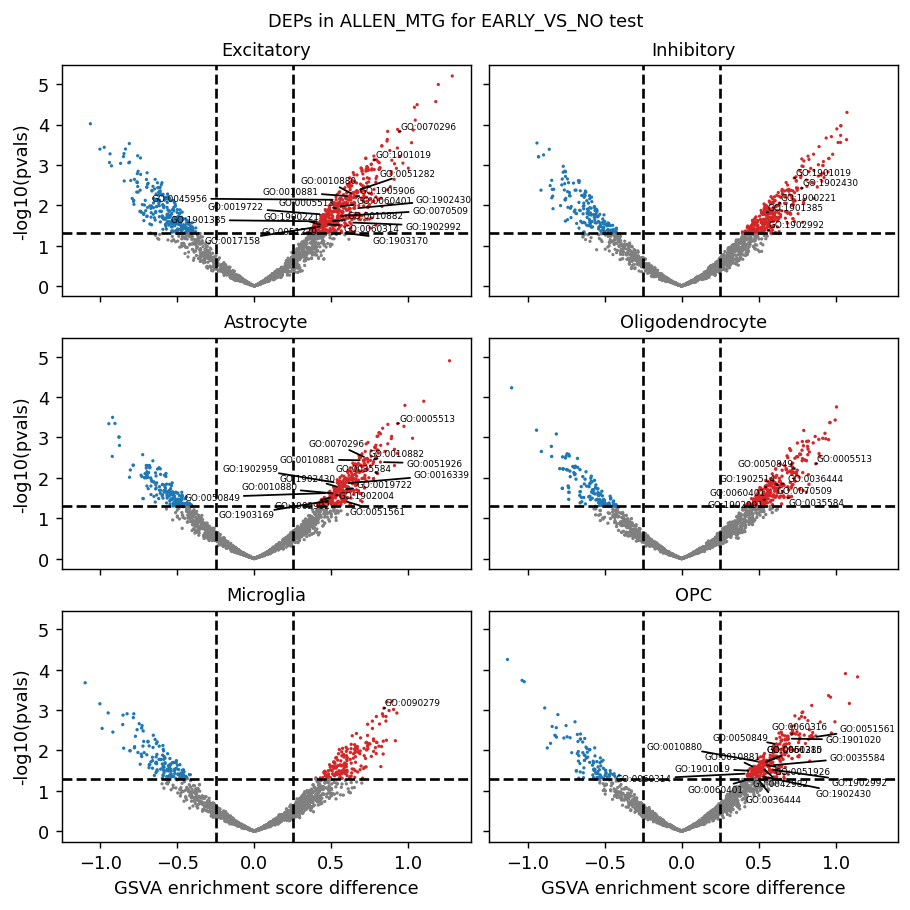

Volcano plot for pathways in ALLEN_MTG for LATE_VS_EARLY test


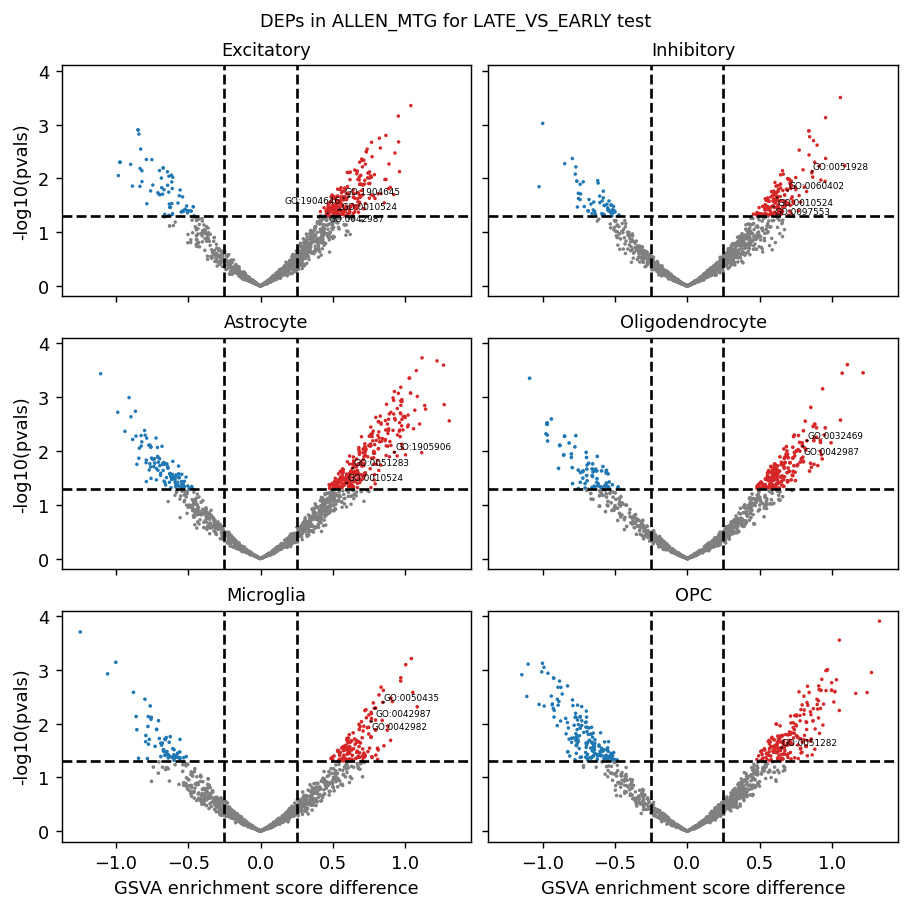

Volcano plot for pathways in ALLEN_MTG for AD_VS_NO test


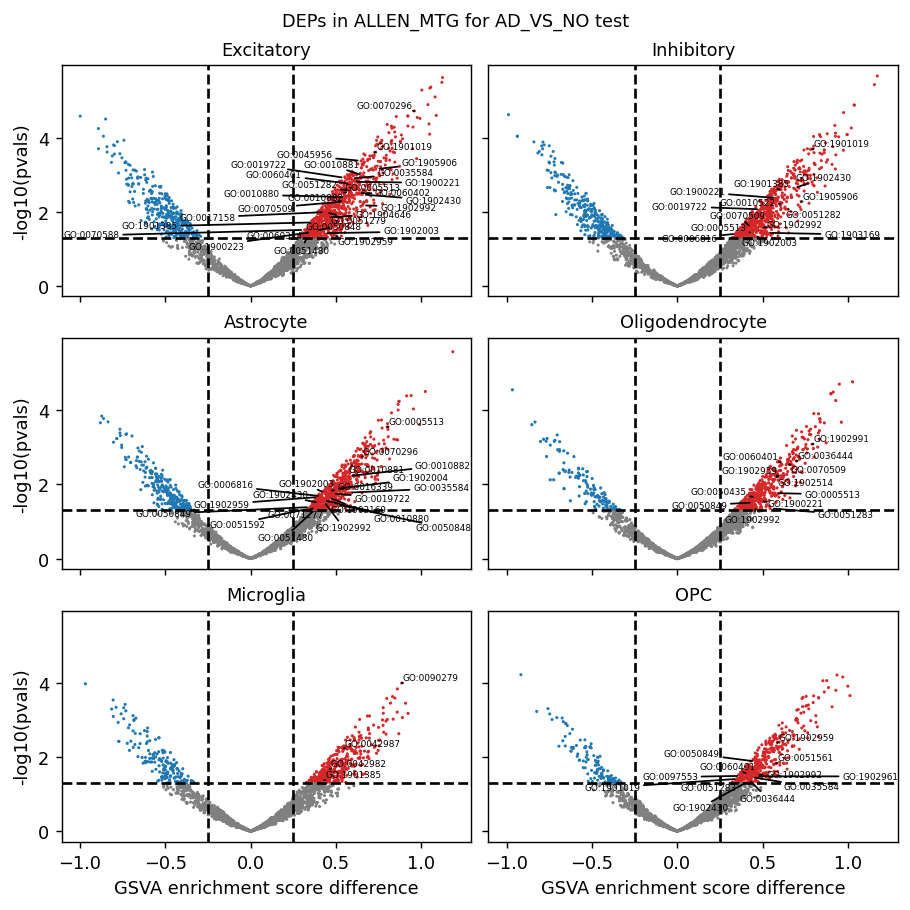

Volcano plot for pathways in ALLEN_MTG for LATE_VS_NO test


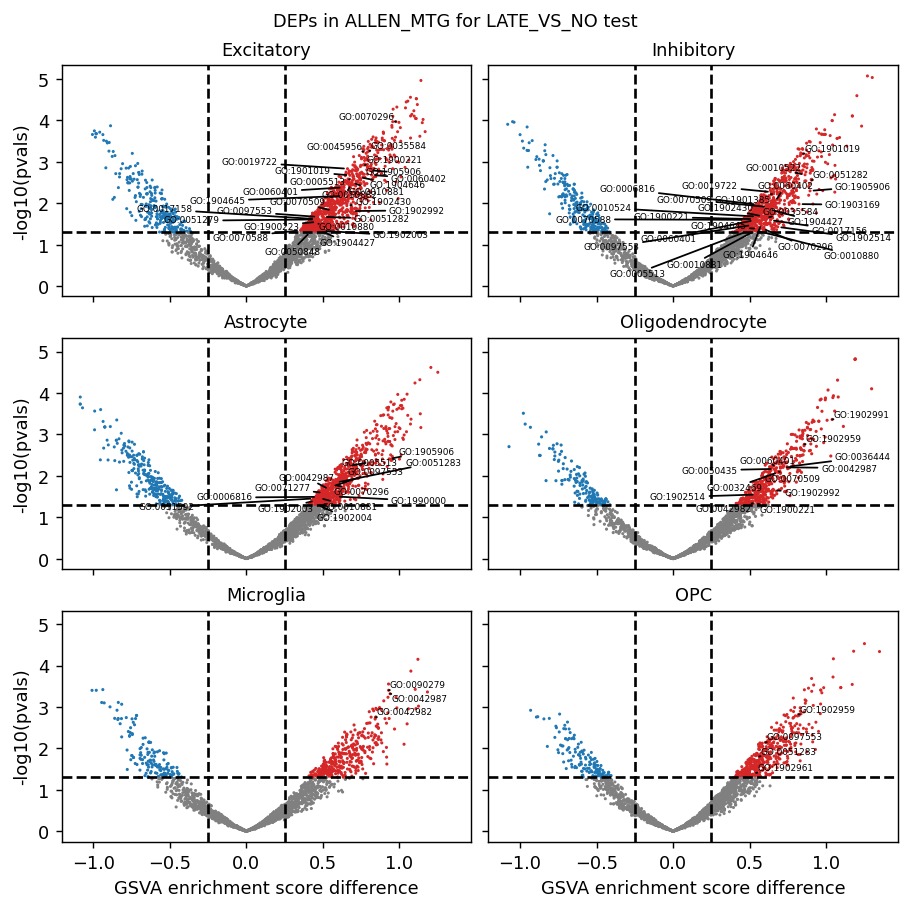

Volcano plot for pathways in LENG_ETC for EARLY_VS_NO test


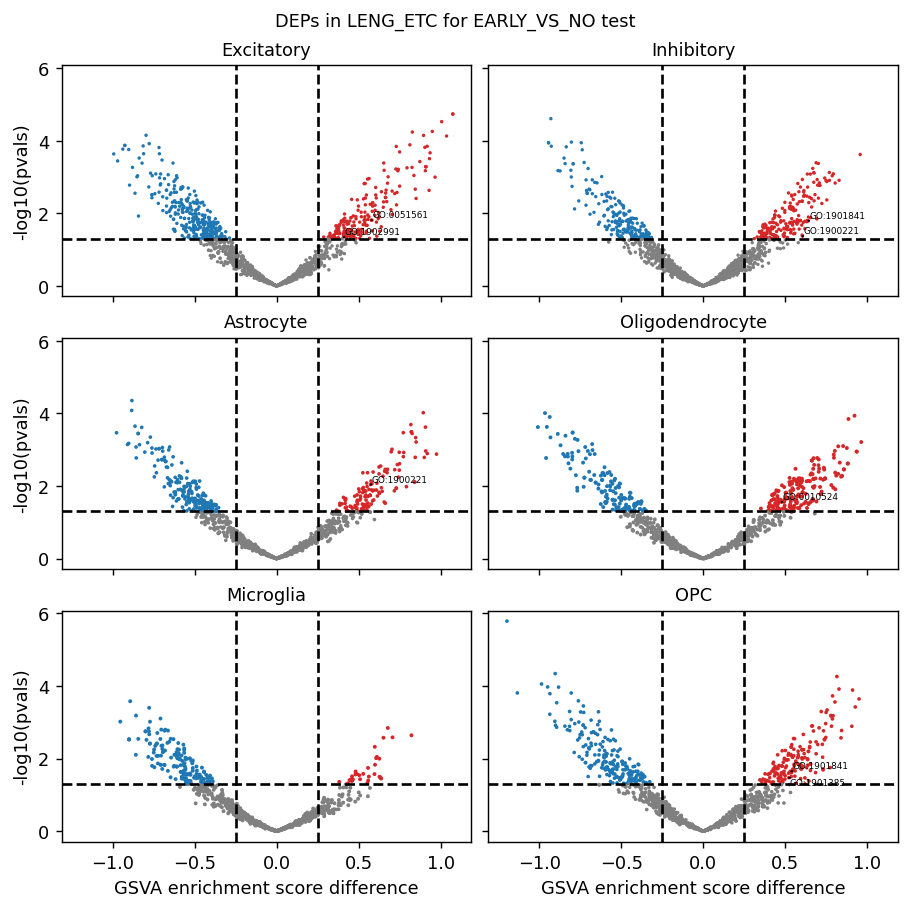

Volcano plot for pathways in LENG_ETC for LATE_VS_EARLY test


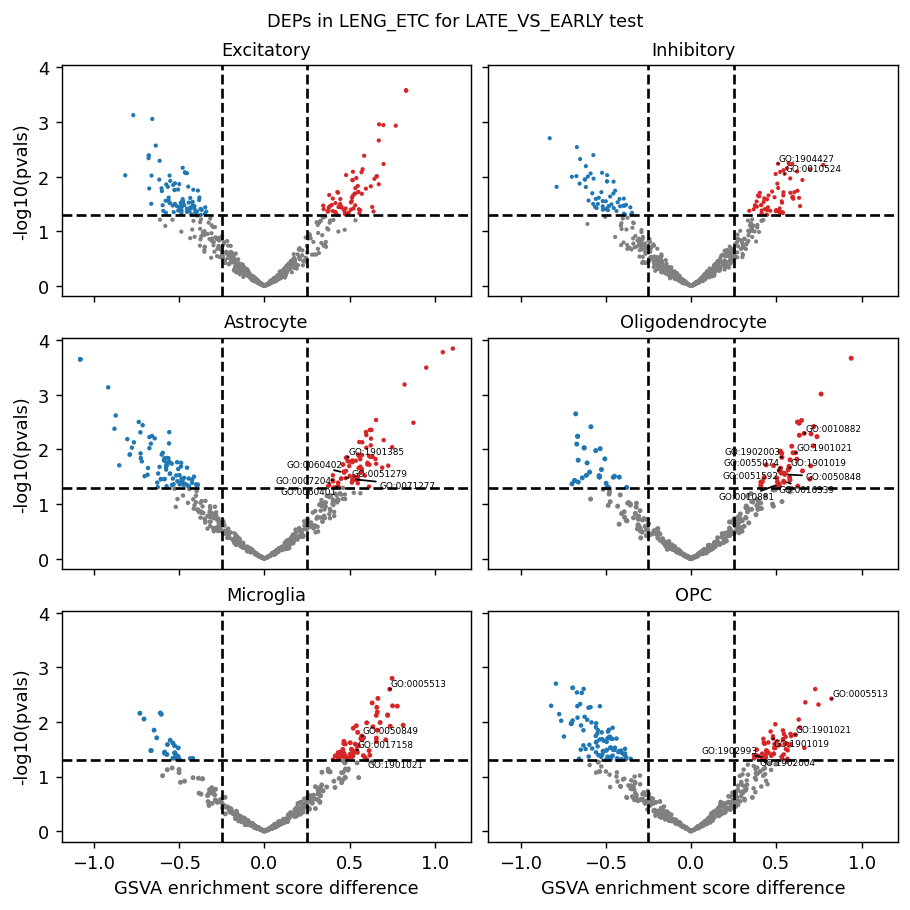

Volcano plot for pathways in LENG_ETC for AD_VS_NO test


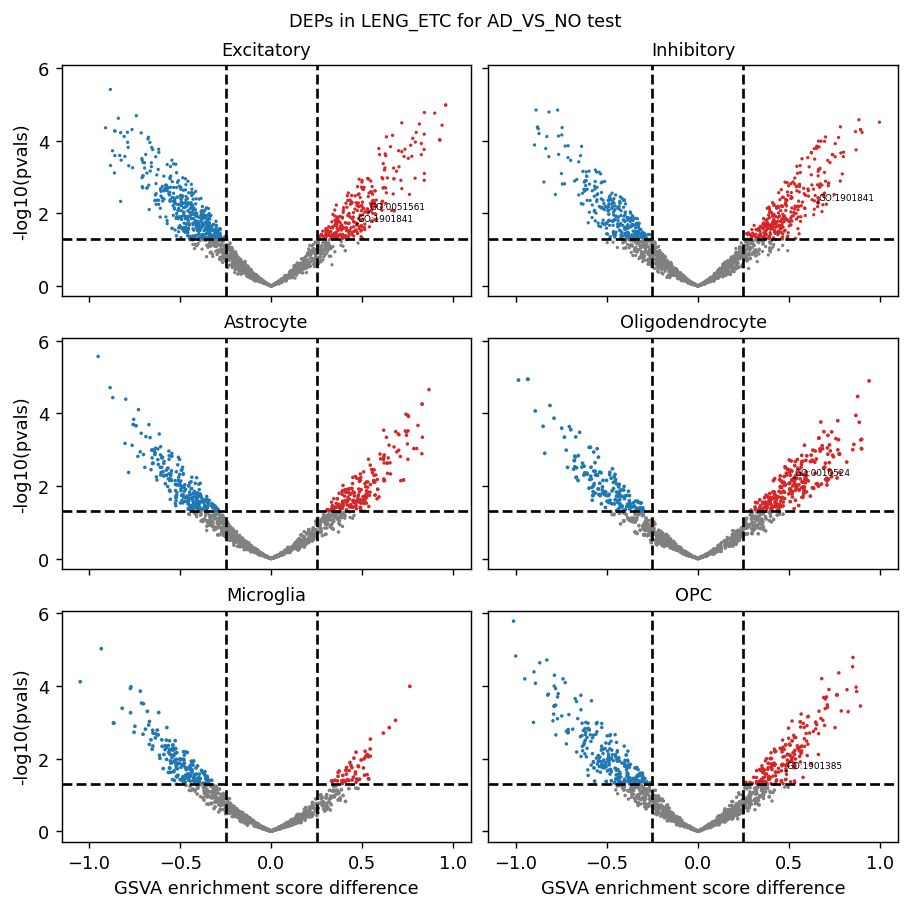

Volcano plot for pathways in LENG_ETC for LATE_VS_NO test


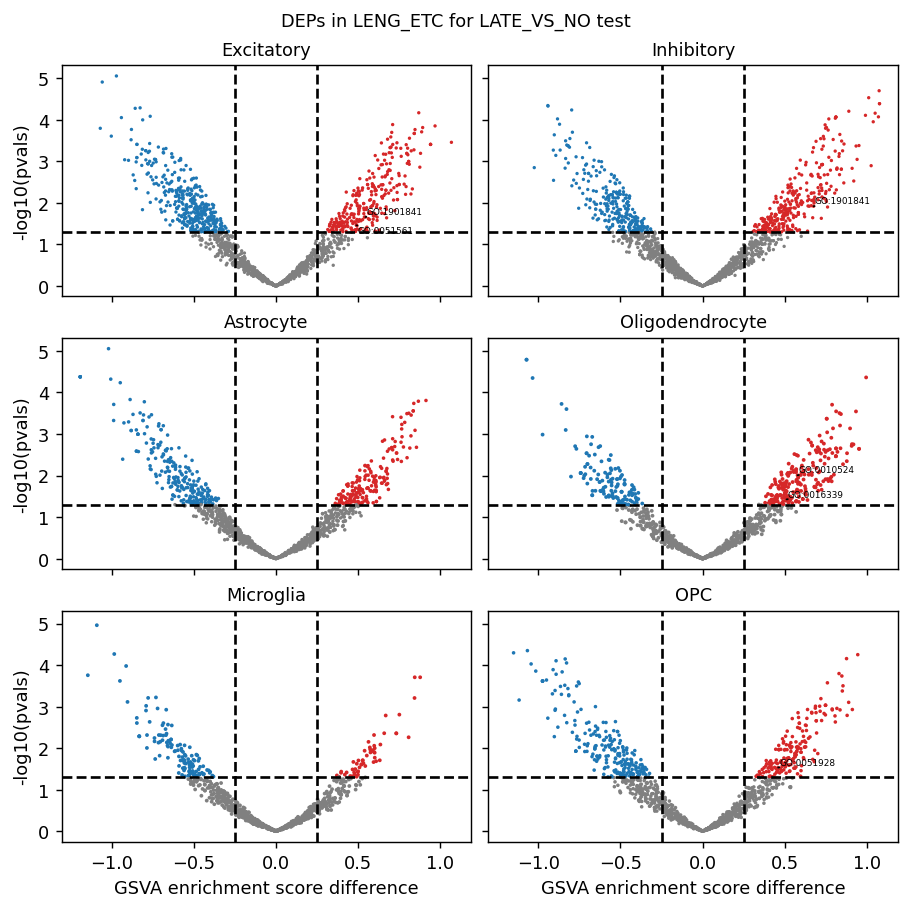

Volcano plot for pathways in LENG_SFG for EARLY_VS_NO test


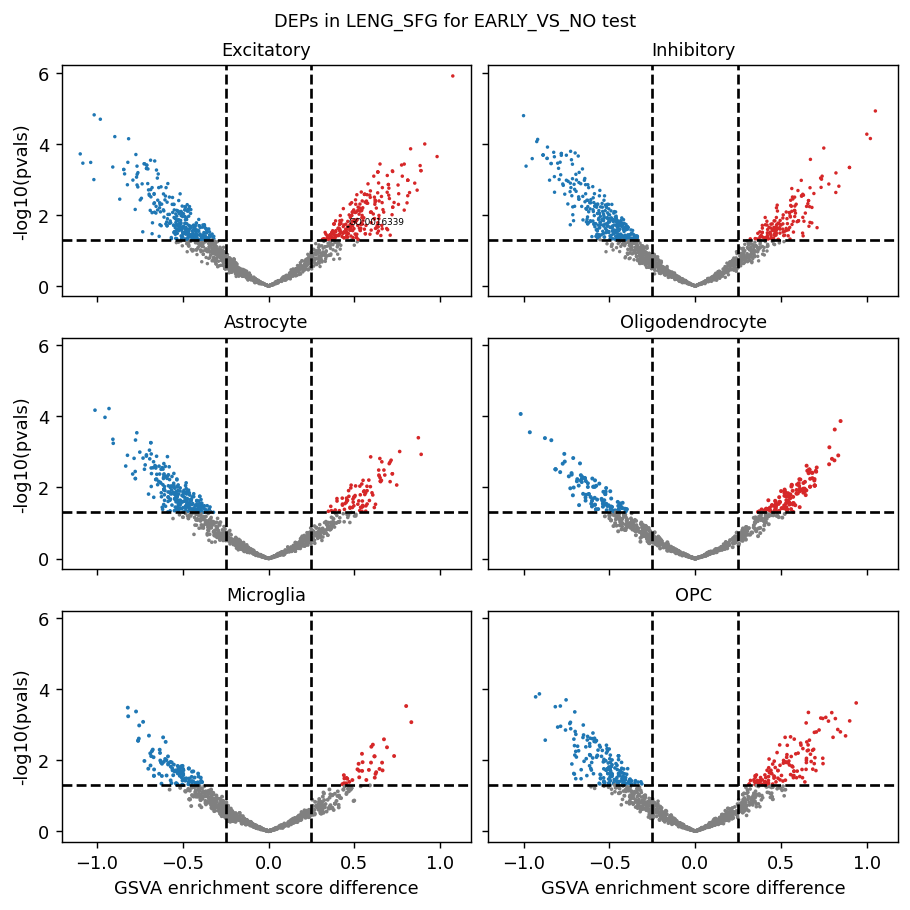

Volcano plot for pathways in LENG_SFG for LATE_VS_EARLY test


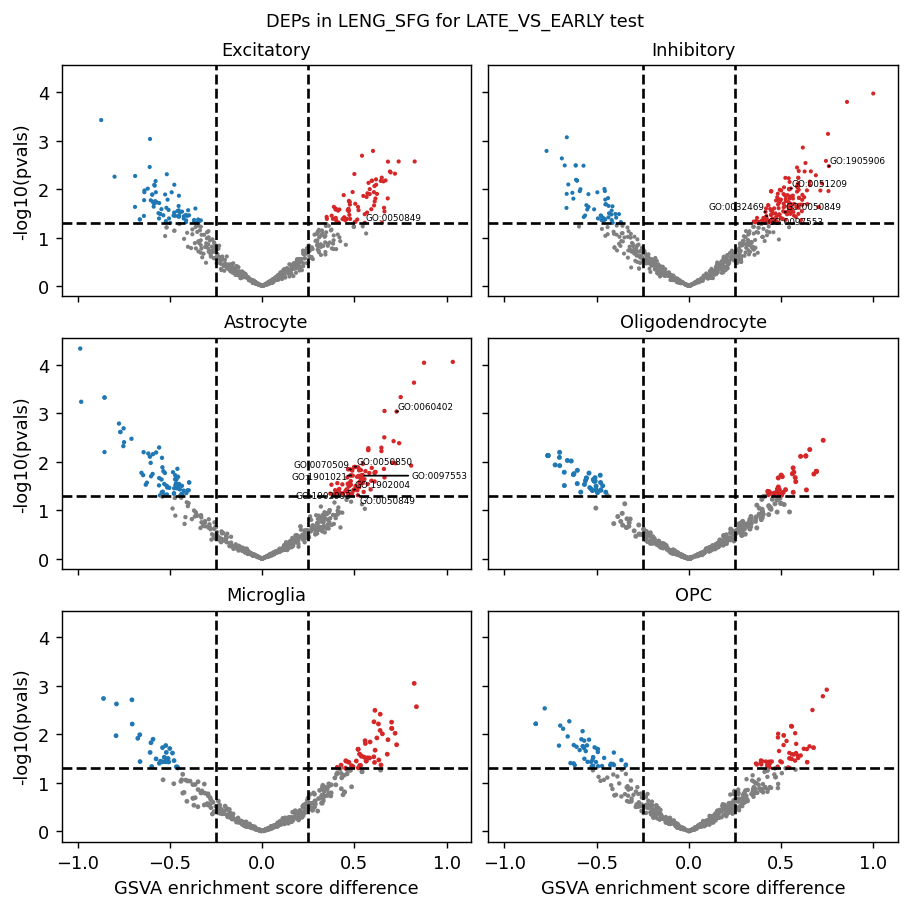

Volcano plot for pathways in LENG_SFG for AD_VS_NO test


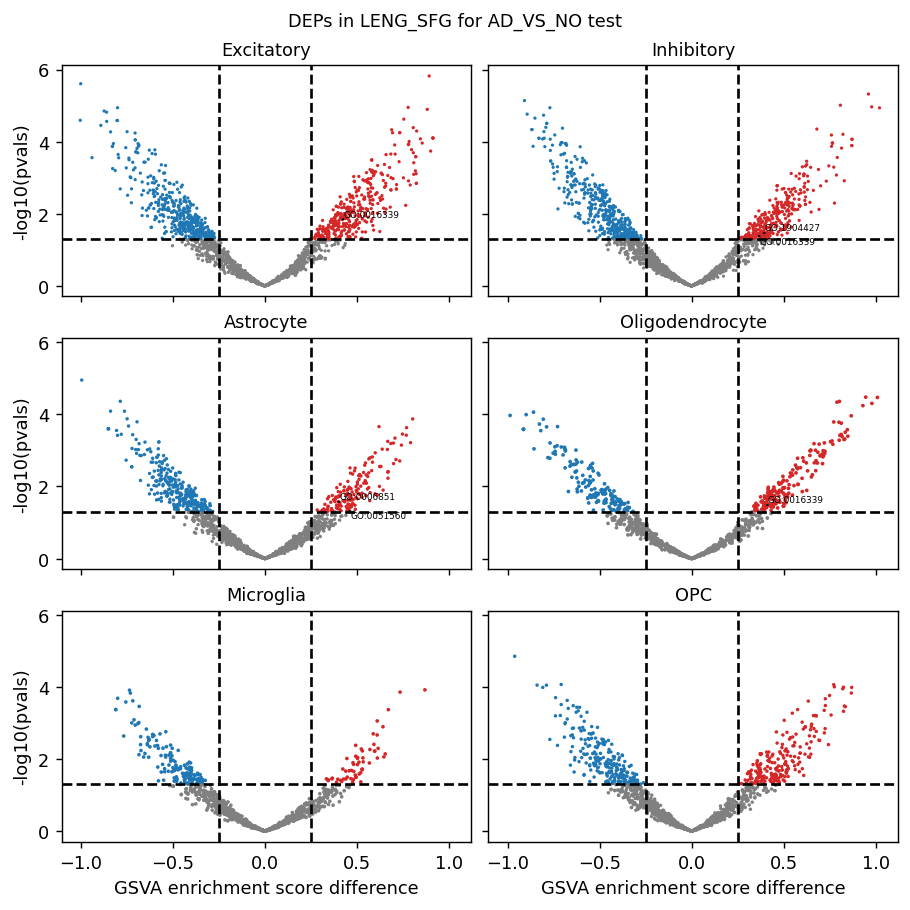

Volcano plot for pathways in LENG_SFG for LATE_VS_NO test


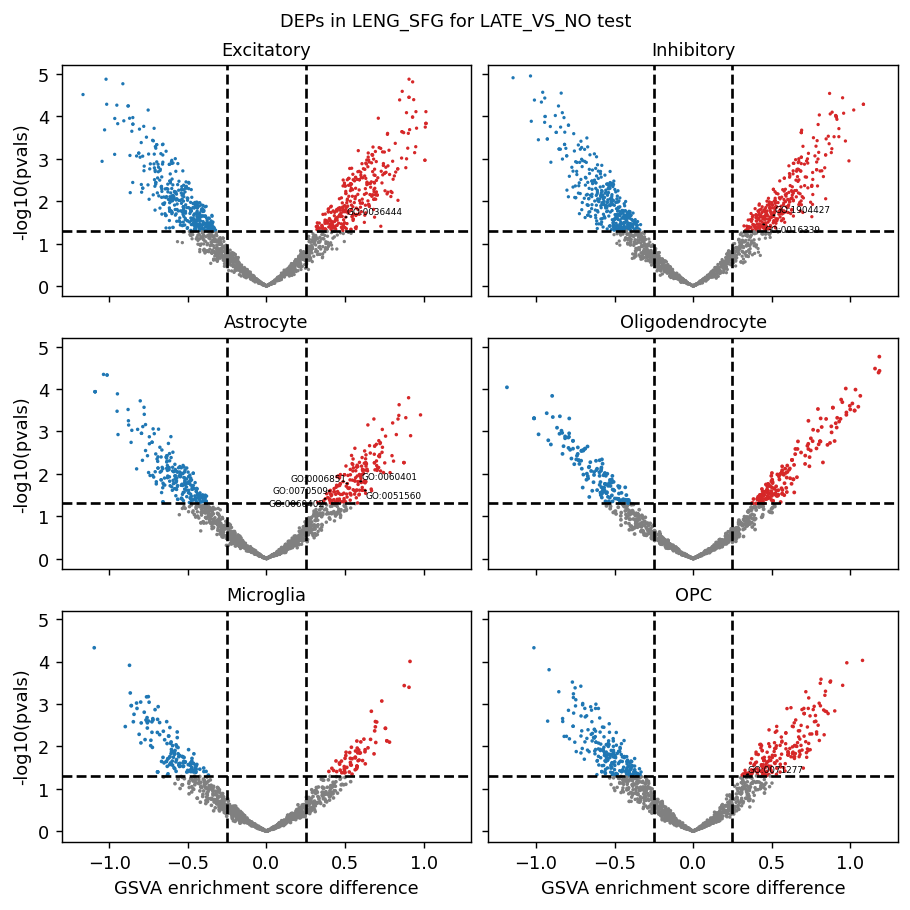

In [19]:
celltypes = ['Excitatory', 'Inhibitory', 'Astrocyte', 'Oligodendrocyte', 'Microglia', 'OPC']
fontsizes = {'on_plot': 5}

for study in studies:
    for test_name in tests:
        print(f'Volcano plot for pathways in {study.upper()} for {test_name.upper()} test')
        all_pathways = pathway_scores[study][test_name].copy()
        all_pathways.index = all_pathways.pathway.apply(lambda x: x.split(' ')[-1].strip('(').strip(')'))
        all_pathways['GSVA enrichment score difference'] = all_pathways['logFC']
    

        fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(7, 7), sharex=True, sharey = True, layout='constrained')
        axs = axs.ravel()

        for ind, cell_type in enumerate(celltypes):

            df = all_pathways[all_pathways.celltype==cell_type]
            
            # names = list(df[(df['pathway'].str.contains('|'.join(['calcium', 'amyloid']))) & \
            #              (df['P.Value'] < 0.05) & \
            #              (abs(df['GSVA enrichment score difference']) > 0.25)].index)
            
            names = list(df[(df['pathway'].str.contains('|'.join(['calcium', 'amyloid']))) & \
                         (abs(df['score_adj'] > 1.3))].index)
                       
            pathway_analyses.plot_volcano(df,
                                            x='GSVA enrichment score difference', y='P.Value',
                                            x_label= 'GSVA enrichment score difference', y_label='-log10(pvals)',
                                            annotate=True, annot_by='name', names=names, top=5,
                                            sign_thr=0.05, lFCs_thr=0.25,
                                            sign_limit=None, lFCs_limit=None, figsize=(7, 5), dpi=100, ax=axs[ind],
                                            return_fig=False, save=None, fontsizes=fontsizes)
           
            axs[ind].set_title(cell_type, fontdict={'fontsize': 10})

        plt.suptitle(f'DEPs in {study.upper()} for {test_name.upper()} test', fontsize=10)   
        plt.savefig(f'../results/{test_name}/{study}_Volcano_plot_for_pathways.pdf')
        plt.show()

### **Upset plot to show how many common/overlapping pathways are shared & how many are cell type specific in each study**

This code generates an upset plot to visualize how many pathways are shared and how many are cell type-specific across multiple studies and tests. The code consists of several sections, each with a specific purpose.

**Section 1: `pathway_scores generation`**

- In this section, `pathway_scores` is generated by reading CSV files for each study and test combination, filtering the pathways based on a p-value threshold, and storing the resulting data frames in a nested list structure.

**Section 3: `Upset plot generation`**

- In this section, an upset plot is generated for each study and test combination. For each study and test combination, the scores for the pathways that are shared among different cell types are extracted from pathway_scores, and the resulting data frame is transformed into a binary matrix that indicates which cell types have a non-zero score for each pathway. The binary matrix is then used to generate an upset plot using the `upset()` function from the `UpSetR` package.

The resulting upset plots visualize the overlap between the pathways that are differentially expressed across different cell types, tests, and studies, providing an intuitive way to understand the relationships between these variables.

In [20]:
%%R -o upset_df -i studies -i tests -i celltypes


library(UpSetR)


color_scheme_celltype <- list()
color_scheme_celltype[['Excitatory']] = 'aquamarine3'
color_scheme_celltype[['Inhibitory']] = 'darkolivegreen3'
color_scheme_celltype[['Astrocyte']] = 'brown3'
color_scheme_celltype[['Oligodendrocyte']] = 'darkorchid3'
color_scheme_celltype[['Microglia']] = 'deepskyblue3'
color_scheme_celltype[['OPC']] = 'deeppink3'


# load all pathways
pathway_scores <- list()

# Loop over each study in a vector of studies
for (study in studies) {
  # Create an empty list to hold pathway scores for the current study
  pathway_scores[[study]] <- list()
  
  # Loop over each test in a vector of tests
  for (test in tests) {
    # Read in pathway data from a CSV file for the current test and study
    all_pathways <- read.csv(sprintf('../results/%s/%s_differentially_expressed_pathways.csv', test, study), header=TRUE)
    
    # Filter the pathway data to select only significant pathways
    pathway_scores[[study]][[test]] <- all_pathways[abs(all_pathways["score_adj"]) > 1.3, ]
  }
}

upset_df <- list() # create an empty list to store the UpSet dataframes for each study
for(study in studies){ # loop through each study
  upset_df[[study]] <- list() # create an empty list to store the UpSet dataframes for each test in the current study
  for(test_name in tests){  # loop through each test
    scores <- pathway_scores[[study]][[test_name]] # subset the pathway scores dataframe to only include pathways that are common to all cell types in the current test
    scores$celltype <- as.character(scores$celltype)  # convert the cell type column to character
    scores$pathway <- factor(as.character(scores$pathway), levels=unique(scores$pathway))  # convert the pathway column to a factor with levels in the order they appear in the scores dataframe

    upset_list <- list()  # create an empty list to store the UpSet table for each cell type
    for(cur_celltype in celltypes){  # loop through each cell type
      test_df <- scores %>% subset(celltype == cur_celltype)  # subset the scores dataframe to only include the current cell type
      upset_list[[cur_celltype]] <- table(test_df$pathway)  # create an UpSet table for the current cell type and store it in the upset_list
    }

    upset_df[[study]][[test_name]] <- as.data.frame(Reduce(cbind, upset_list))
    colnames(upset_df[[study]][[test_name]]) <- celltypes

    # remove entries with all 0
    upset_df[[study]][[test_name]] <- upset_df[[study]][[test_name]][rowSums(upset_df[[study]][[test_name]]) > 0,]
  
    # convert to binary
    upset_df[[study]][[test_name]][upset_df[[study]][[test_name]] > 0] <- 1
    
    svg(paste0('../results/', test_name, '/upset_individual_', study,'.svg'), width=8, height=4)
    # Get the names of the columns in the upset_df dataframe
    col_names <- colnames(upset_df[[study]][[test_name]])

    # Match the names in color_scheme_celltype to the column names in upset_df
    cur_color_scheme <- unlist(color_scheme_celltype)[match(col_names, names(color_scheme_celltype))]

    # Order the colors based on the column sums and reverse the order
    cur_color_scheme <- cur_color_scheme[order(colSums(upset_df[[study]][[test_name]]), decreasing = TRUE)]

    print(upset(upset_df[[study]][[test_name]],
              sets=as.character(celltypes),
              #group.by='sets',
              order.by='freq',
              #cutoff=4,
              sets.bar.color=cur_color_scheme,
            ))
    dev.off()

    

    pdf(paste0('../results/', test_name, '/upset_individual_', study,'.pdf'), width=8, height=4)
    # Get the names of the columns in the upset_df dataframe
    col_names <- colnames(upset_df[[study]][[test_name]])

    # Match the names in color_scheme_celltype to the column names in upset_df
    cur_color_scheme <- unlist(color_scheme_celltype)[match(col_names, names(color_scheme_celltype))]

    # Order the colors based on the column sums and reverse the order
    cur_color_scheme <- cur_color_scheme[order(colSums(upset_df[[study]][[test_name]]), decreasing = TRUE)]

    print(upset(upset_df[[study]][[test_name]],
              sets=as.character(celltypes),
              #group.by='sets',
              order.by='freq',
              #cutoff=4,
              sets.bar.color=cur_color_scheme,
            ))
    dev.off()
  }
}

Fontconfig warning: ignoring UTF-8: not a valid region tag


### **Heatmap Visualizing Shared Differential Pathway Expression Across All Studies**

We can visualize heatmaps of pathways that overlap across all studies. This can be done either by searching for an overall overlap across all studies irrespective of cell-type specificity by setting the argument `method='global_overlap'` or by looking for cell-type specific overlap by setting `method='cell_type_overlap'`.

To filter and annotate only select pathways, we can set `filter=True `and pass a list of pathways as an argument, as described in the previous section. 

In [21]:
pathways_to_annotate = pd.read_excel('../data/pathway_databases/pathways_to_annotate.xlsx')
filtered_pathways = pathways_to_annotate['pathway'].to_list()

heatmap for select cell-type-specific pathways in early_vs_no test


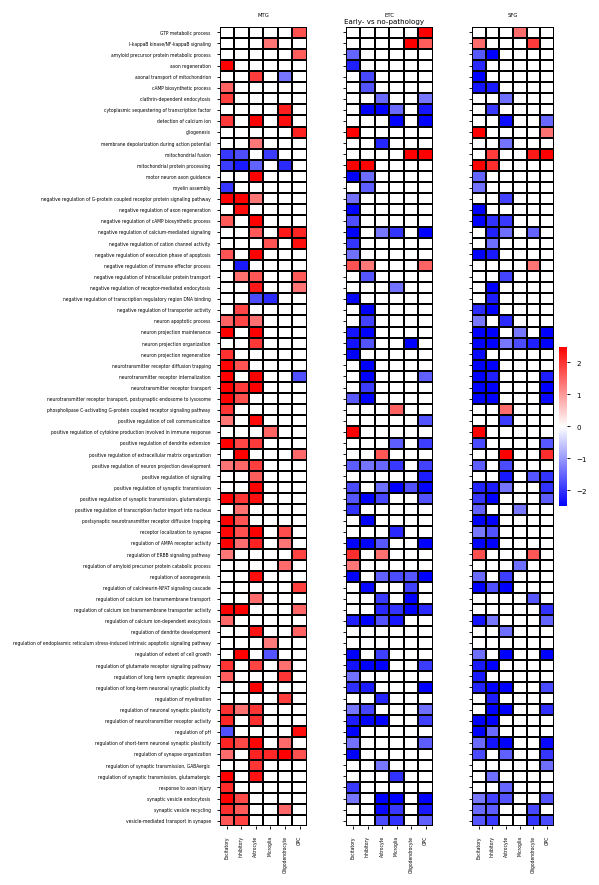

heatmap for select cell-type-specific pathways in late_vs_early test


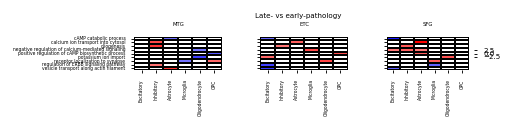

heatmap for select cell-type-specific pathways in ad_vs_no test


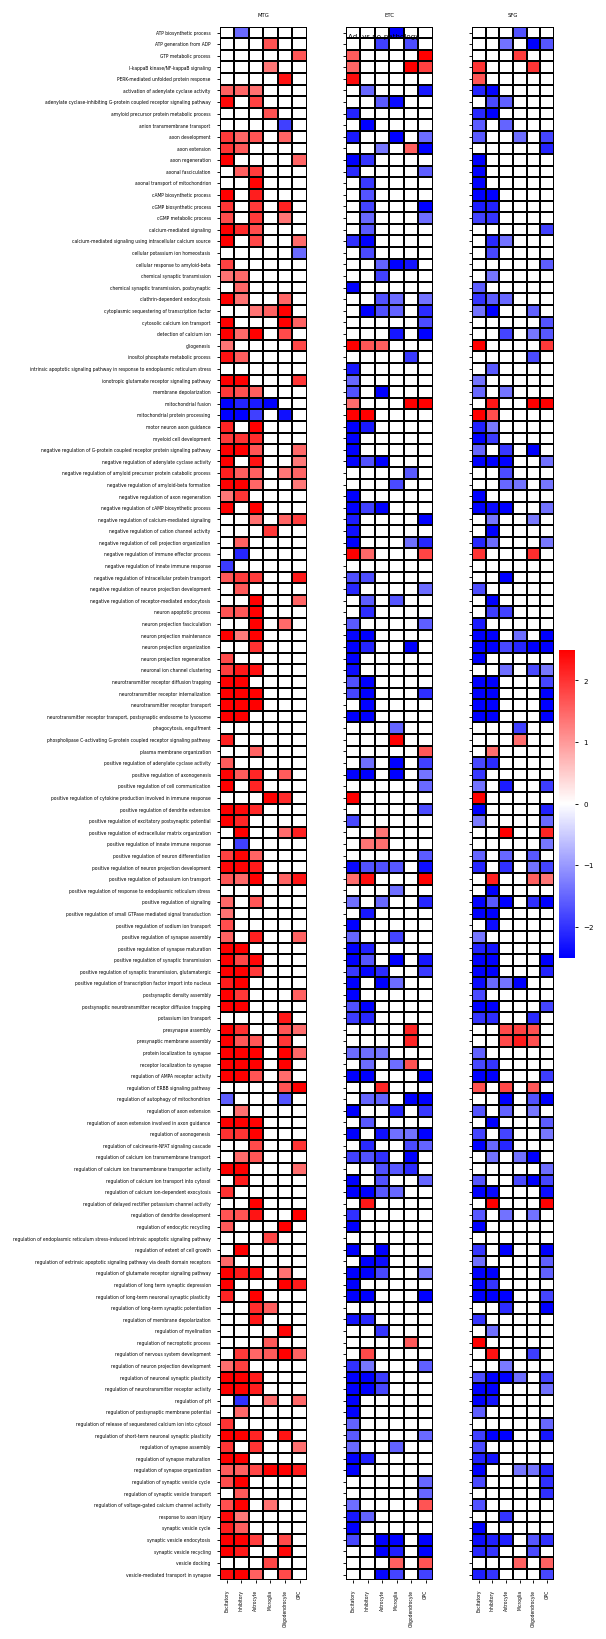

heatmap for select cell-type-specific pathways in late_vs_no test


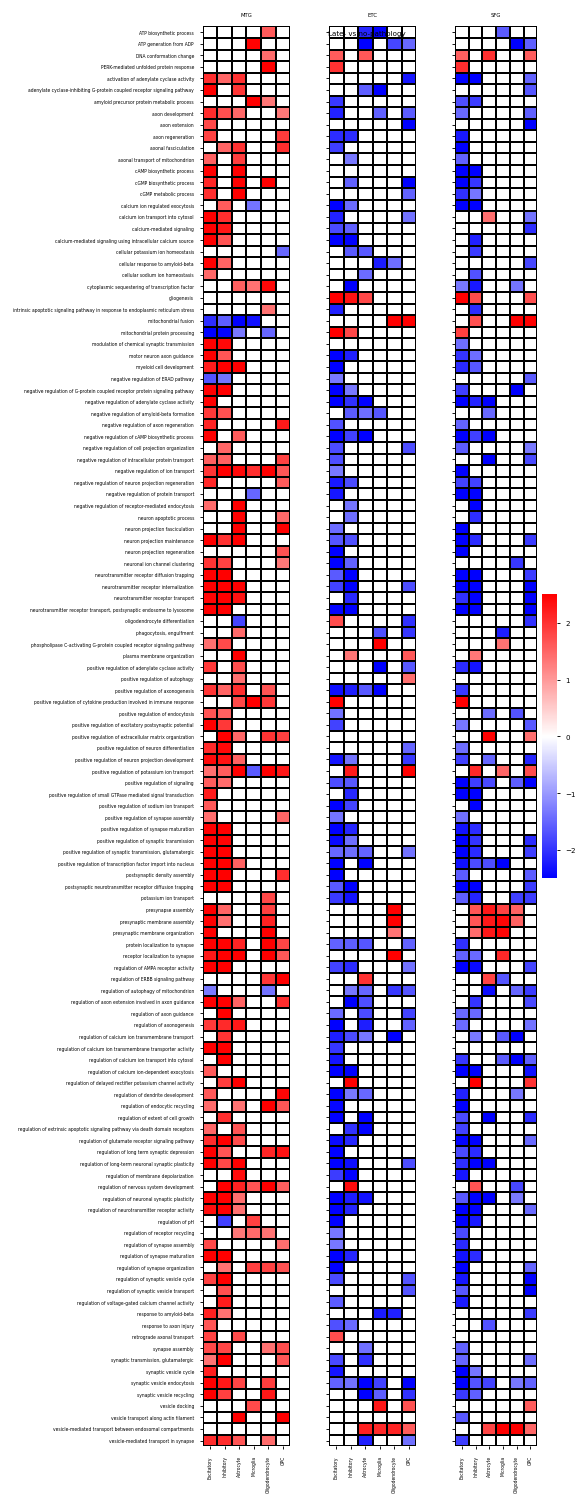

In [23]:
overlap_scores = {}

for test_name in tests:
    print(f'heatmap for select cell-type-specific pathways in {test_name} test')
    overlap_scores[test_name] = pathway_analyses.multi_study_pathway_overlap(pathway_scores=pathway_scores,
                                                                             p_thresh=0.05,
                                                                             filtered_pathways=filtered_pathways,
                                                                             cell_types = ["Excitatory", "Inhibitory", "Astrocyte",
                                                                                            "Microglia", "Oligodendrocyte", "OPC"],
                                                                             test_name = test_name,
                                                                             top_n = 10,
                                                                             pathways = [],
                                                                             filter = True,
                                                                             save_suffix = test_name,
                                                                             method='global_overlap')


try:
    scores_for_overlapping_paths = robjects.ListVector({test_name: robjects.vectors.StrVector(overlap_scores[test_name].index.to_list()) for test_name in tests})
except AttributeError:
    temp_tests = []
    for test_name in test:
        if len(overlap_scores.index)>0:
            temp_tests.append(test_name)
        else:
            print(f"AttributeError occurred for test_name: {test_name}")
    scores_for_overlapping_paths = robjects.ListVector({test_name: robjects.vectors.StrVector(overlap_scores[test_name].index.to_list()) for test_name in temp_tests})


#### **Using ComplexHeatmap in R**

In [23]:
%%R -i list_of_paths_to_annotate -i tests -i studies -o common_pathways

library(readxl)
library(ComplexHeatmap)
library(circlize)
library(tidyr)

source('../scripts/functions/pathway_analyses.R')

cell_types = c("Excitatory", "Inhibitory", "Astrocyte", "Microglia", "Oligodendrocyte", "OPC")

# import the renamed-pathway names

print('importing pathway renaming convention')

path_names_go <- as.data.frame(read_excel('../data/pathway_databases/pathways_to_annotate.xlsx'))
# path_names_go <- data.frame(pathway = unique(path_names_go$pathway))
rownames(path_names_go) <- path_names_go$pathway

# shortened names of pathways that will be annotated
names = as.vector(list_of_paths_to_annotate)


# load all pathways
pathway_scores <- list()

# Loop over each study in a vector of studies
for (study in studies) {
  # Create an empty list to hold pathway scores for the current study
  pathway_scores[[study]] <- list()
  
  # Loop over each test in a vector of tests
  for (test_name in tests) {
    # Read in pathway data from a CSV file for the current test and study
    all_pathways <- read.csv(sprintf('../results/%s/%s_differentially_expressed_pathways.csv', test_name, study), header=TRUE)

    # Filter the pathway data to select only significant pathways
    pathway_scores[[study]][[test_name]] <- all_pathways[abs(all_pathways["score_adj"]) > 1.3, ]
  }
}


# Create an empty list to hold common pathways across tests and studies
common_pathways <- list()

# Loop over each test in a vector of tests
for (test_name in tests) {
  
  cur_study_pathways <- list()
  
  for (study in studies) {
    cur_study_pathways[[study]] <- pathway_scores[[study]][[test_name]]

    # Extract unique pathway names as character strings
    cur_study_pathways[[study]] <- as.character(unique(cur_study_pathways[[study]]$pathway))
  }
  
  # Compute the intersection of pathways across all studies for the current test
  common_pathways[[test_name]] <- Reduce(intersect, cur_study_pathways)
}



# Loop over each test in a vector of tests
for (test_name in tests) {

  h <- list()
  ha <- NULL
  # Loop over each study in a vector of studies
  for (study in studies) {

    scores <- pathway_scores[[study]][[test_name]][pathway_scores[[study]][[test_name]]$pathway %in% common_pathways[[test_name]], ]

    
    # Filter the pathway data to select only significant pathways
    scores[scores$P.Value > 0.05, "score_adj"] <- 0
    pathway_scores_subset <- scores[, c("pathway", "celltype", "score_adj")]
    pivot_table <- pathway_scores_subset %>% pivot_wider(names_from = "celltype", values_from = "score_adj")

    # Set pathway column as row names
    pivot_table <- as.data.frame(pivot_table)

    # Set the 'pathway' column as the row names (index)
    row.names(pivot_table) <- pivot_table$pathway

    # Remove the 'pathway' column from the data frame
    pivot_table$pathway <- NULL
    mat <- pivot_table[, cell_types]
    mat <- mat[rownames(mat) %in% path_names_go$pathway, ] 
    
    # draw heatmap for all GO pathways
    print('drawing heatmaps - GO')
    h[[study]] = get_go_hmap(mat, names, path_names_go, 'shortened_name', reorder=TRUE)

  }

  pdf(paste0('../results/', test_name, '/', 'multi_study_pathway_overlap_filtered_R','.pdf'), height = 21, width = 55.5)
  print(Reduce('+', h))
  dev.off()

}


[1] "importing pathway renaming convention"
New names:
• `` -> `...1`
[1] "drawing heatmaps - GO"
[1] "drawing heatmaps - GO"
[1] "drawing heatmaps - GO"
[1] "drawing heatmaps - GO"
[1] "drawing heatmaps - GO"
[1] "drawing heatmaps - GO"
[1] "drawing heatmaps - GO"
[1] "drawing heatmaps - GO"
[1] "drawing heatmaps - GO"
[1] "drawing heatmaps - GO"
[1] "drawing heatmaps - GO"
[1] "drawing heatmaps - GO"


### **Venn Diagrams showing number of overlapping pathways across all studiess in each cell type**

This code generates Venn diagrams that show the number of overlapping pathways across all studies in each cell type. The code reads in pathway data from multiple studies and creates a Venn diagram for each cell type. The Venn diagram is generated using the matplotlib-venn library. 

The pathway data is first processed to obtain a set of pathways for each cell type. Then, the sets are combined to create a master set of pathways that includes all pathways across all cell types. The number of pathways that are unique to each cell type and the number of pathways that are shared between cell types are determined using set operations. The resulting values are then used to generate the Venn diagrams.

The code uses a loop to iterate through each cell type and generate a Venn diagram for that cell type. The Venn diagrams are saved to disk as PNG files.


In [31]:
%%R -i studies -i tests -i celltypes

library(VennDiagram)
library(gridExtra)
library(Seurat)
library(Signac)
library(tidyverse)
library(future.apply)
library(ggpubr)
library(reshape2)
library(tictoc)
library(patchwork)
library(ggridges)
library(RColorBrewer)
library(eulerr)
library(GeneOverlap)

# load all pathways
pathway_scores <- list()
studies <- studies

# Loop over each study in a vector of studies
for (study in studies) {
  # Create an empty list to hold pathway scores for the current study
  pathway_scores[[study]] <- list()
  
  # Loop over each test in a vector of tests
  for (test in tests) {
    # Read in pathway data from a CSV file for the current test and study
    all_pathways <- read.csv(sprintf('../results/%s/%s_differentially_expressed_pathways.csv', test, study), header=TRUE)
    
    # Filter the pathway data to select only significant pathways
    pathway_scores[[study]][[test]] <- all_pathways[all_pathways["P.Value"] < 0.05, ]
  }
}

# create a list of unique cell types

# Upset plot to show how many target genes are shared & how many are cell type specific

fisher_df <- data.frame()
color_scheme_celltype <- list()
color_scheme_celltype[['Excitatory']] = 'aquamarine3'
color_scheme_celltype[['Inhibitory']] = 'darkolivegreen3'
color_scheme_celltype[['Astrocyte']] = 'brown3'
color_scheme_celltype[['Oligodendrocyte']] = 'darkorchid3'
color_scheme_celltype[['Microglia']] = 'deepskyblue3'
color_scheme_celltype[['OPC']] = 'deeppink3'
  

for(test_name in tests){
    
  for(cur_celltype in celltypes){
    
      # get diagnosis DEGs for this celltype:
      # cur_degs <- celltype.diagnosis.markers %>% subset(cluster == 'AD' & celltype ==  cur_celltype & avg_logFC >= 0)
    
      # get celltype degs for this celltype:

      cur_celltype_pathways_mtg <- pathway_scores[['allen_mtg']][[test_name]] %>% subset(celltype == cur_celltype)
      cur_celltype_pathways_etc <- pathway_scores[['leng_etc']][[test_name]] %>% subset(celltype == cur_celltype)
      cur_celltype_pathways_sfg <- pathway_scores[['leng_sfg']][[test_name]] %>% subset(celltype == cur_celltype)
    
      # overlap between links and diagnosis degs
      # diag_overlap_pval <- testGeneOverlap(newGeneOverlap(
      #   unique(cur_celltype_pathways_mtg$pathway),
      #   unique(cur_celltype_pathways_etc$pathway),
      #   genome.size=length(intersect(rownames(NucSeq), proj@peakSet$nearestGene))
      # ))@pval
    
      # celltype_overlap_pval <- testGeneOverlap(newGeneOverlap(
      #   cur_celltype_degs$gene,
      #   unique(cur_links$Peak1_nearestGene),
      #   genome.size=length(intersect(rownames(NucSeq), proj@peakSet$nearestGene))
      # ))@pval
      # 
      
      # update fisher df:
      # diag_df <- data.frame(pval = diag_overlap_pval, celltype=cur_celltype, type='diagnosis')
      # celltype_df <- data.frame(pval = celltype_overlap_pval, celltype=cur_celltype, type='celltype')
    
      # fisher_df <- Reduce(rbind, list(fisher_df, diag_df, celltype_df))
    
      # set up relevant lists:
      pathway_set_list <- list(
        'MTG' = as.character(unique(cur_celltype_pathways_mtg$pathway)),
        'ETC' = as.character(cur_celltype_pathways_etc$pathway),
        'SFG' = as.character(cur_celltype_pathways_sfg$pathway)
      )
      # pathway_set_list[['allen_mtg']]
    
      venn_list <- list()
      for(i in 1:length(pathway_set_list)){
        cur_pathways <- pathway_set_list[[i]]
    
        other_indices <- (i:length(pathway_set_list))[i:length(pathway_set_list) != i]
    
        # number of pathways in cur set and not other sets:
        venn_list[[names(pathway_set_list)[i]]] <- sum(!(cur_pathways %in% Reduce(union, pathway_set_list[other_indices])))
    
    
        for(j in other_indices){
          other_pathways <- pathway_set_list[[j]]
          venn_list[[paste0(names(pathway_set_list)[i],'&',names(pathway_set_list)[j])]] <- length(intersect(cur_pathways, other_pathways))
        }
      }
    
      # number of pathways in common between all sets:
      venn_list[[paste0(names(pathway_set_list)[1], '&', names(pathway_set_list)[2], '&', names(pathway_set_list)[3])]] <- length(Reduce(intersect, pathway_set_list))
    
    
      VennDiag <- euler(unlist(venn_list))
      svg(paste0('../results/', test_name, '/venn_',cur_celltype,'.svg'), width=6, height=6)
  
      print(plot(
        VennDiag, quantities=TRUE, counts = TRUE, font=5, cex=1, alpha=0.8,
        fill=rep(color_scheme_celltype[[cur_celltype]], 3)
      ))
      dev.off()

      pdf(paste0('../results/', test_name, '/venn_',cur_celltype,'.pdf'), width=6, height=6)  
      print(plot(
        VennDiag, quantities=TRUE, counts = TRUE, font=5, cex=1, alpha=0.8,
        fill=rep(color_scheme_celltype[[cur_celltype]], 3)
      ))
      dev.off()

    }
}

  # # add significance stars:
  # fisher_df$significance <- stars.pval(fisher_df$pval)
  # 
  # fisher_df$significance <- ifelse(
  #   fisher_df$pval > 0.05, 'n.s.', ifelse(
  #   fisher_df$pval >= 0.05, '*', ifelse(
  #   fisher_df$pval >= 0.005, '**', '***'
  # )))

### **Upset plot to show how many pathways are shared & how many are cell type specific across the overlapping pathways**

This code generates an upset plot to visualize how many pathways are shared and how many are cell type-specific across multiple studies and tests. The code consists of several sections, each with a specific purpose.

**Section 1: `pathway_scores generation`**

- In this section, `pathway_scores` is generated by reading CSV files for each study and test combination, filtering the pathways based on a p-value threshold, and storing the resulting data frames in a nested list structure.

**Section 2: `common_pathways generation`**

- In this section, `common_pathways` is generated by finding the pathways that are shared among the same cell types across different studies for each test. This is done by iterating through each study and test combination, extracting the pathways that correspond to each cell type and using the `Reduce()` and `intersect()` functions to find the pathways that are common across all studies. This list is used to obtain genes to visualize in the circular heatmap.

**Section 3: `Upset plot generation`**

- In this section, an upset plot is generated for each study and test combination. For each study and test combination, the scores for the pathways that are shared among different cell types are extracted from pathway_scores, and the resulting data frame is transformed into a binary matrix that indicates which cell types have a non-zero score for each pathway. The binary matrix is then used to generate an upset plot using the `upset()` function from the `UpSetR` package.

The resulting upset plots visualize the overlap between the pathways that are differentially expressed across different cell types, tests, and studies, providing an intuitive way to understand the relationships between these variables.

In [26]:
%%R -o upset_df -o common_pathways -i studies -i tests -i celltypes


library(UpSetR)


color_scheme_celltype <- list()
color_scheme_celltype[['Excitatory']] = 'aquamarine3'
color_scheme_celltype[['Inhibitory']] = 'darkolivegreen3'
color_scheme_celltype[['Astrocyte']] = 'brown3'
color_scheme_celltype[['Oligodendrocyte']] = 'darkorchid3'
color_scheme_celltype[['Microglia']] = 'deepskyblue3'
color_scheme_celltype[['OPC']] = 'deeppink3'


# load all pathways
pathway_scores <- list()

# Loop over each study in a vector of studies
for (study in studies) {
  # Create an empty list to hold pathway scores for the current study
  pathway_scores[[study]] <- list()
  
  # Loop over each test in a vector of tests
  for (test in tests) {
    # Read in pathway data from a CSV file for the current test and study
    all_pathways <- read.csv(sprintf('../results/%s/%s_differentially_expressed_pathways.csv', test, study), header=TRUE)
    
    # Filter the pathway data to select only significant pathways
    pathway_scores[[study]][[test]] <- all_pathways[all_pathways["P.Value"] < 0.05, ]
  }
}


# Create an empty list to hold common pathways across tests and cell types
common_pathways <- list()

# Loop over each test in a vector of tests
for(test_name in tests){
  
  # Create an empty list to hold common pathways for the current test across cell types
  common_pathways[[test_name]] <- list()
  
  # Loop over each cell type in a vector of cell types
  for(cur_celltype in celltypes){

    # Create an empty list to hold pathways for the current cell type in each study
    cur_celltype_pathways <- list()
    
    for(study in studies){
      # Select pathway scores for the current test and study that match the current cell type
      cur_celltype_pathways[[study]] <- pathway_scores[[study]][[test_name]] %>% subset(celltype == cur_celltype)
      
      # Extract unique pathway names as character strings
      cur_celltype_pathways[[study]] <- as.character(unique(cur_celltype_pathways[[study]]$pathway))
    }
    # Compute the intersection of pathways across all studies for the current cell type
    common_pathways[[test_name]][[cur_celltype]] <- Reduce(intersect, cur_celltype_pathways)
  }
      
  # Flatten the list of common pathways across cell types into a single vector
  common_pathways[[test_name]] <- unlist(common_pathways[[test_name]], recursive = FALSE)
}


upset_df <- list() # create an empty list to store the UpSet dataframes for each study
for(study in studies){ # loop through each study
  upset_df[[study]] <- list() # create an empty list to store the UpSet dataframes for each test in the current study
  for(test_name in tests){  # loop through each test
    scores <- pathway_scores[[study]][[test_name]][pathway_scores[[study]][[test_name]]$pathway %in% unique(common_pathways[[test_name]]), ]  # subset the pathway scores dataframe to only include pathways that are common to all cell types in the current test
    scores$celltype <- as.character(scores$celltype)  # convert the cell type column to character
    scores$pathway <- factor(as.character(scores$pathway), levels=unique(scores$pathway))  # convert the pathway column to a factor with levels in the order they appear in the scores dataframe

    upset_list <- list()  # create an empty list to store the UpSet table for each cell type
    for(cur_celltype in celltypes){  # loop through each cell type
      test_df <- scores %>% subset(celltype == cur_celltype)  # subset the scores dataframe to only include the current cell type
      upset_list[[cur_celltype]] <- table(test_df$pathway)  # create an UpSet table for the current cell type and store it in the upset_list
    }

    upset_df[[study]][[test_name]] <- as.data.frame(Reduce(cbind, upset_list))
    colnames(upset_df[[study]][[test_name]]) <- celltypes

    # remove entries with all 0
    upset_df[[study]][[test_name]] <- upset_df[[study]][[test_name]][rowSums(upset_df[[study]][[test_name]]) > 0,]
  
    # convert to binary
    upset_df[[study]][[test_name]][upset_df[[study]][[test_name]] > 0] <- 1
    
    svg(paste0('../results/', test_name, '/upset_overlap_', study,'.svg'), width=8, height=4)
    # Get the names of the columns in the upset_df dataframe
    col_names <- colnames(upset_df[[study]][[test_name]])

    # Match the names in color_scheme_celltype to the column names in upset_df
    cur_color_scheme <- unlist(color_scheme_celltype)[match(col_names, names(color_scheme_celltype))]

    # Order the colors based on the column sums and reverse the order
    cur_color_scheme <- cur_color_scheme[order(colSums(upset_df[[study]][[test_name]]), decreasing = TRUE)]

    print(upset(upset_df[[study]][[test_name]],
              sets=as.character(celltypes),
              #group.by='sets',
              order.by='freq',
              #cutoff=4,
              sets.bar.color=cur_color_scheme,
            ))
    dev.off() 

    pdf(paste0('../results/', test_name, '/upset_overlap_', study,'.pdf'), width=8, height=4)
    # Get the names of the columns in the upset_df dataframe
    col_names <- colnames(upset_df[[study]][[test_name]])

    # Match the names in color_scheme_celltype to the column names in upset_df
    cur_color_scheme <- unlist(color_scheme_celltype)[match(col_names, names(color_scheme_celltype))]

    # Order the colors based on the column sums and reverse the order
    cur_color_scheme <- cur_color_scheme[order(colSums(upset_df[[study]][[test_name]]), decreasing = TRUE)]

    print(upset(upset_df[[study]][[test_name]],
              sets=as.character(celltypes),
              #group.by='sets',
              order.by='freq',
              #cutoff=4,
              sets.bar.color=cur_color_scheme,
            ))
    dev.off()
  }
}

### **Circular HeatMap DEGs in all pathways for each test**

#### **Load DEGs** 

In [27]:
degs = {}
merged_degs = {}
deg_methods =  ['edgeR-QLF', 'DESeq2-Wald', 'limma-voom']


for study in studies:

    degs[study] = {}
    merged_degs[study] = {}

    for test in tests:
      
        degs[study][test] = {}
        merged_degs[study][test] = {}

        for method in deg_methods:
         
            degs[study][test][method] = {}
            merged_degs[study][test][method] = {}
            merged_df = pd.DataFrame(columns=['gene'])

            for cell_type in celltypes:
                degs[study][test][method][cell_type] = pd.read_excel(f'../results/{test}/{study}_{method}_degs.xlsx', 
                                                                            sheet_name=cell_type,)
                
                df = degs[study][test][method][cell_type]
                df = df.rename(columns={'avg_logFC': f'{cell_type}_logFC', 'p_val_adj': f'{cell_type}_Pvalue'})
                merged_df = pd.merge(merged_df, df[['gene', f'{cell_type}_logFC', f'{cell_type}_Pvalue']], on='gene', how='outer')
        
            merged_degs[study][test][method]['logFC'] = merged_df[['gene'] + list(merged_df.filter(like='logFC').columns)]
            merged_degs[study][test][method]['Pvals'] = merged_df[['gene'] + list(merged_df.filter(like='Pvalue').columns)]



# convert nested dataframe into Rpy2 object 

all_degs =  robjects.ListVector(
                        {
                            study: robjects.ListVector(
                                {
                                    test_name: robjects.ListVector(
                                        {
                                            method: robjects.ListVector(
    
                                                {stat: pandas2ri.py2rpy(merged_degs[study][test_name][method][stat])
                                                 
                                                    for stat in ['logFC', 'Pvals']
                                                }
                                            )
                                            for method in deg_methods
                                        }
                                    )
                                    for test_name in tests
                                }
                            )
                            for study in studies
                        }
                    )



#### **Load Genes In Each Pathway** 

In the **`../scripts/pathway_analysis.ipynb`** notebook, we have preprocessed the pathways and filtered genes that do not meet a certain threshold (typically **`<5%`** in a cell-type) in each of the the studies.

These filtered pathways were saved to **`../results/gsva/{study_name}/{cell_type}`**.

We next visualize the expression pattern of these genes using the circular heatmap


In [28]:
%%R -o geneSets -i studies -i tests -i celltypes -i scores_for_overlapping_paths -i all_degs -i deg_methods


library(EnhancedVolcano)
library(circlize)
library(GSEABase)
library(GSVA) 
library(ComplexHeatmap)



color_scheme_celltype <- list()
color_scheme_celltype[['Excitatory']] = 'aquamarine3'
color_scheme_celltype[['Inhibitory']] = 'darkolivegreen3'
color_scheme_celltype[['Astrocyte']] = 'brown3'
color_scheme_celltype[['Oligodendrocyte']] = 'darkorchid3'
color_scheme_celltype[['Microglia']] = 'deepskyblue3'
color_scheme_celltype[['OPC']] = 'deeppink3'



# iterate over celltypes and obtain 
geneSets <- list()
for(test_name in tests){

  geneSets[[test_name]] <- list()
  for (study in studies){

    geneSets[[test_name]][[study]] <- list()
    for (cur_celltype in celltypes){
        # get gene sets
        geneSets[[test_name]][[study]][[cur_celltype]] <- getGmt(file.path('../results/gsva/', study, '/', cur_celltype, 'gs.gmt'))
        geneSets[[test_name]][[study]][[cur_celltype]] <- geneIds(geneSets[[test_name]][[study]][[cur_celltype]])

        # Check if test_name exists in scores_for_overlapping_paths
        if (test_name %in% names(scores_for_overlapping_paths)) {
          geneSets[[test_name]][[study]][[cur_celltype]] <-  geneSets[[test_name]][[study]][[cur_celltype]][names(geneSets[[test_name]][[study]][[cur_celltype]]) %in% scores_for_overlapping_paths[[test_name]]]
          } else {
          geneSets[[test_name]][[study]][[cur_celltype]] <- character(0)  # Set an empty vector if no scores exist
        }
      

        geneSets[[test_name]][[study]][[cur_celltype]] <- unlist(geneSets[[test_name]][[study]][[cur_celltype]], recursive = FALSE)
    }
    geneSets[[test_name]][[study]] <- unlist(geneSets[[test_name]][[study]], recursive = FALSE)
  }
}

for (study in studies){
  for (test_name in tests){
    if (test_name %in% names(scores_for_overlapping_paths)) {
      for (method in deg_methods){

        # for (stat in c('logFC', 'Pvals')){
        
        mat1 = subset(all_degs[[study]][[test_name]][[method]][['logFC']], gene %in% geneSets[[test_name]][[study]])
        mat2 = subset(all_degs[[study]][[test_name]][[method]][['Pvals']], gene %in% geneSets[[test_name]][[study]])

        rownames(mat1) <- mat1[, "gene"]
        rownames(mat2) <- mat2[, "gene"]

        mat1[is.na(mat1)] <- 0
        mat2[is.na(mat2)] <- 1

        mat1 <- mat1[, -which(colnames(mat1) == "gene")]
        mat2 <- -log10(mat2[, -which(colnames(mat2) == "gene")])

        pdf(paste0('../results/', test_name, '/', study, '_circular_heatmap_', method, '.pdf'), width=8, height=4)

        # col_fun1 = colorRamp2(c(min(mat1), 0, max(mat1)), c("blue", "white", "red"))
        # col_fun2 = colorRamp2(c(min(mat2), max(mat2)), c("white", "green"))

        col_fun1 = colorRamp2(c(-5, 0, 5), c("blue", "white", "red"))
        col_fun2 = colorRamp2(c(0, 6), c("white", "green"))
        
        # circos.initialize()
        circos.heatmap.initialize(mat1)

        circos.heatmap(mat1, split = NULL, col = col_fun1, dend.side = "outside")
        circos.heatmap(mat2, split = NULL, col = col_fun2,)

        lgd1 <- Legend(col_fun = col_fun1, title = "log(Fold Change)",
                      direction = "horizontal", title_position = "topcenter", 
                      legend_width = unit(2, "cm"), legend_height = unit(0.1, "cm"))
        # grid.draw(lgd1)

        lgd2 <- Legend(col_fun = col_fun2, title = "-log10(FDR)", 
                      direction = "horizontal", title_position = "topcenter",
                      legend_width = unit(2, "cm"), legend_height = unit(0.1, "cm"))
        # grid.draw(lgd2)

        plgd <- packLegend(lgd1, lgd2, direction = "vertical")

        grid.draw(plgd)
        print(circos.par(gap.after = c(90)))

        circos.clear()
        dev.off()


        svg(paste0('../results/', test_name, '/', study, '_circular_heatmap_', method, '.svg'), width=8, height=4)


        # col_fun1 = colorRamp2(c(min(mat1), 0, max(mat1)), c("blue", "white", "red"))
        # col_fun2 = colorRamp2(c(min(mat2), max(mat2)), c("white", "green"))

        col_fun1 = colorRamp2(c(-5, 0, 5), c("blue", "white", "red"))
        col_fun2 = colorRamp2(c(0, 6), c("white", "green"))
        
        # circos.initialize()
        circos.heatmap.initialize(mat1)

        circos.heatmap(mat1, split = NULL, col = col_fun1, dend.side = "outside")
        circos.heatmap(mat2, split = NULL, col = col_fun2,)

        lgd1 <- Legend(col_fun = col_fun1, title = "log(Fold Change)",
                      direction = "horizontal", title_position = "topcenter", 
                      legend_width = unit(2, "cm"), legend_height = unit(0.1, "cm"))
        # grid.draw(lgd1)

        lgd2 <- Legend(col_fun = col_fun2, title = "-log10(FDR)", 
                      direction = "horizontal", title_position = "topcenter",
                      legend_width = unit(2, "cm"), legend_height = unit(0.1, "cm"))
        # grid.draw(lgd2)

        plgd <- packLegend(lgd1, lgd2, direction = "vertical")

        grid.draw(plgd)
        print(circos.par(gap.after = c(90)))

        circos.clear()
        dev.off()

        # }
        
      } 
    } 
  }
}

NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL


### **Parent Class distrubution of the overlapping pathways in each test**

Next, for all the overlapping pathways in eact test, we would like to know which parent groups are predominant. This will help us understand how consesnus is maintained with pathological progression. That is are there are qualitative changes in pathway perturbations during early- versus late-stage AD pathology?

To do this, we obtain the list of all consesus pathways in each test and then obtain the parent GO term of each consensus pathway at several nodes.

In [29]:
# overlap_scores = {}
# go_node_depths = [1, 2, 3, 4, 5, 6, 7, 8]

# # Calculate overlap scores for each test
# for test_name in tests:
#     print(f"Heatmap of overlapping pathways in {test_name} test")
    
#     overlap_scores[test_name] = pathway_analyses.multi_study_pathway_overlap(
#         pathway_scores=pathway_scores,
#         p_thresh=0.05,
#         filtered_pathways=filtered_pathways,
#         cell_types=["Excitatory", "Inhibitory", "Astrocyte", "Microglia", "Oligodendrocyte", "OPC"],
#         test_name=test_name,
#         top_n=10,
#         pathways=[],
#         filter=False,
#         save_suffix=test_name,
#         method='global_overlap'
#     )

#     # Extract parent node depths for each study
#     for study in studies:
#         overlap_scores[test_name][study]['GO'] = overlap_scores[test_name][study].index.to_series().apply(
#             lambda x: x.split(' ')[-1].strip('(').strip(')')
#         )
        
#         # Calculate parent node at different depths
#         for depth in go_node_depths:
#             overlap_scores[test_name][study][f'parent_at_node_{depth}'] = overlap_scores[test_name][study]['GO'].apply(
#                 lambda x: get_parent_at_depth(x, depth)
#             )


# count_overlapping_parents = {}

# # Count overlapping parents for each study and depth


# for depth in go_node_depths:
#     count_overlapping_parents[depth] = {}
    
#     fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(11, 4), sharex=True, sharey = True, layout='constrained')
#     axs = axs.ravel()

#     print(f'Class distribution of overlapping pathways at {depth}')


#     for ind, study in enumerate(studies):
#         count_overlapping_parents[depth][study] = pd.DataFrame()
        
#         # Merge parent counts for each test
#         for test_name in tests:
#             count_overlapping_parents[depth][study] = count_overlapping_parents[depth][study].merge(
#                 pd.DataFrame(overlap_scores[test_name][study][f'parent_at_node_{depth}'].value_counts()),
#                 left_index=True,
#                 right_index=True,
#                 how='outer'
#             )
            
#             # Rename the column with the test name
#             count_overlapping_parents[depth][study].rename(
#                 columns={count_overlapping_parents[depth][study].columns[-1]: f'{test_name}'},
#                 inplace=True
#             )


#         melted = count_overlapping_parents[depth][study].reset_index().melt(id_vars='index', 
#                                                                             var_name='Condition',
#                                                                             value_name='Count')
        
        
#         sb.barplot(data=melted, x='Count', y='index',
#                 hue='Condition', orient='h', ax=axs[ind], linewidth=4)

#         axs[ind].set_title(study, fontdict={'fontsize': 10})
#         axs[ind].yaxis.label.set_fontsize(4) 

#     plt.suptitle(f'Class distribution of pathways', fontsize=10)   
#     plt.savefig(f'../results/pathway_meta_analysis/class_dist_of_all_overlapping_pathways_at_node_depth_{depth}.pdf')
#     plt.show()
    
#     plt.show()
  

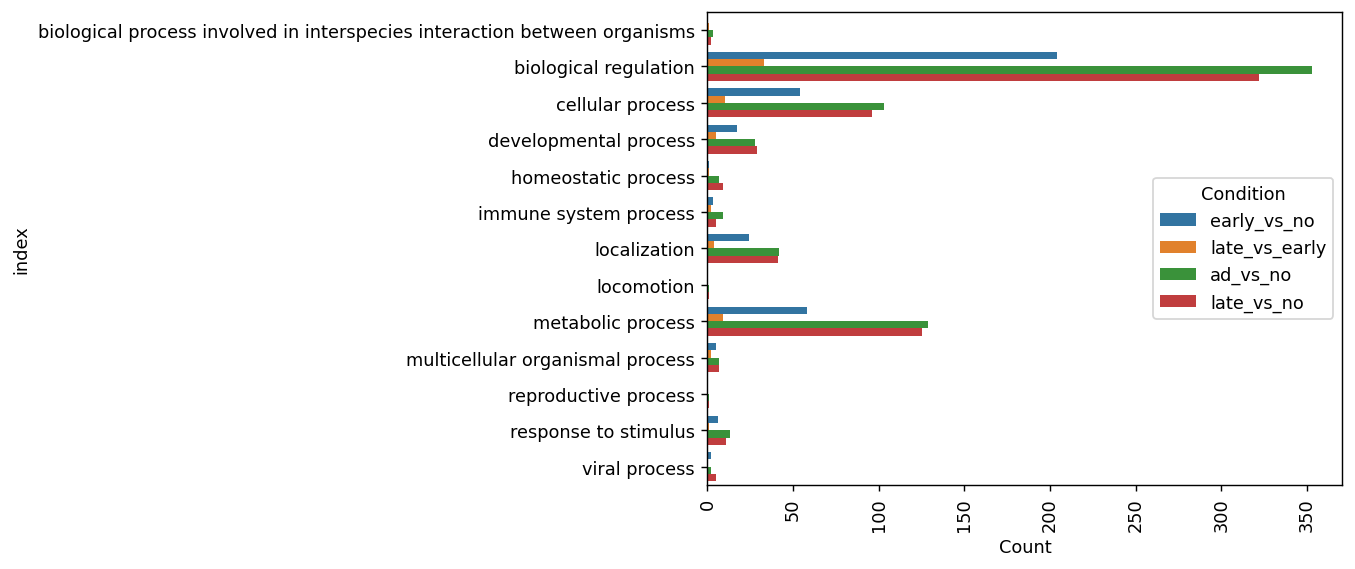

In [100]:
# Plot the bar chart
